In [1]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = True
%load_ext sql

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import pickle
import datetime

In [3]:
# データベースに接続
conn = sqlite3.connect('tataki.sqlite3')
curs = conn.cursor()

In [4]:
df=pd.read_sql_query('SELECT * FROM tataki', conn)
# print(df)
print(len(df))

26400


In [5]:
# カーソルとコネクションをクローズする
curs.close()
conn.close()

In [6]:
# // array(1次元)をtargetLengsの長さにする
def getArrayLengsChange(array, targetLengs):
    targetArray = [0] * targetLengs
    if len(array) == targetLengs:
        return array
    # 長さ100を長さ3にするとしたら、25, 50, 75番目を選んでる
    elif len(array)> targetLengs:
        targetIndexTips = len(array) / (targetLengs + 1)
        k = 1
        targetIndex = int(targetIndexTips * k)
        for i in range(targetLengs):
            targetArray[i] =array[targetIndex]
            k += 1
            targetIndex = int(targetIndexTips * k)
    # 長さ13から長さ16への変換でデータを3個追加するとしたら、13を(3+1)等分した箇所にデータを追加する
    elif len(array) < targetLengs:
        diff = targetLengs - len(array)
        targetIndexTips = targetLengs / (diff + 1)
        k = 1
        targetIndex = int(targetIndexTips * k)
        j = 0
        for i in range(targetLengs):
            if i == targetIndex:
                if j == 0:
                    targetArray[i] = array[j]
                else:
                    targetArray[i] = (array[j-1] + array[j]) / 2
                k += 1
                targetIndex = int(targetIndexTips * k);
            else:
                targetArray[i] = array[j]
                j += 1
    return targetArray

In [9]:
# numpyにして高速化

from sklearn import preprocessing

leng = 16

np_zurasi = np.array([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
zurasi_bai = np_zurasi.shape[0]

noise_bai = 5 #ノイズでn倍

dlen = 6*leng #ノイズデータのデータ長
mean = 0.0    #ノイズの平均値
std  = 0.1    #ノイズの分散


np_ax = df['AX'].to_numpy()
np_ay = df['AY'].to_numpy()
np_az = df['AZ'].to_numpy()
# np_rx = df['RX'].to_numpy()
# np_ry = df['RY'].to_numpy()
# np_rz = df['RZ'].to_numpy()

np_rx = df['RZ'].to_numpy()
np_ry = df['RX'].to_numpy()
np_rz = df['RY'].to_numpy()

np_kindsSumaho = df['kindsSumaho'].to_numpy()
np_orientation = df['orientation'].to_numpy()
np_kindsTataki = df['kindsTataki'].to_numpy()

# n個を持った配列を用意しておくと早くなる(しておかないとめっちゃ遅い)
data_num = df.shape[0] * zurasi_bai * noise_bai
mynps = np.empty((data_num, leng, 6))

print('df.shape[0]:', df.shape[0])
data_num_count = 0
for idx in range(df.shape[0]):
# for idx in range(1):
    if(np_kindsTataki[idx] != np_kindsTataki[idx - 1]):
        print(idx, np_kindsSumaho[idx], np_orientation[idx], np_kindsTataki[idx])
    
    # 長さを変える
    ax = np_ax[idx].split(',')
    ax = list(map(lambda x: float(x), ax))
    ax = getArrayLengsChange(ax, leng)
#     ax = preprocessing.scale(ax)
    
    ay = np_ay[idx].split(',')
    ay = list(map(lambda x: float(x), ay))
    ay = getArrayLengsChange(ay, leng)
#     ay = preprocessing.scale(ay)
    
    az = np_az[idx].split(',')
    az = list(map(lambda x: float(x), az))
    az = getArrayLengsChange(az, leng)
#     az = preprocessing.scale(az)
    
    rx = np_rx[idx].split(',')
    rx = list(map(lambda x: float(x), rx))
    rx = getArrayLengsChange(rx, leng)
#     rx = preprocessing.scale(rx)
    
    ry = np_ry[idx].split(',')
    ry = list(map(lambda x: float(x), ry))
    ry = getArrayLengsChange(ry, leng)
#     ry = preprocessing.scale(ry)
    
    rz = np_rz[idx].split(',')
    rz = list(map(lambda x: float(x), rz))
    rz = getArrayLengsChange(rz, leng)
#     rz = preprocessing.scale(rz)
    
    # 加速度と角速度ごとに標準化
    ax = np.array(ax)
    ay = np.array(ay)
    az = np.array(az)
    rx = np.array(rx)
    ry = np.array(ry)
    rz = np.array(rz)
    
    ax = ax.reshape(-1, 1)
    ay = ay.reshape(-1, 1)
    az = az.reshape(-1, 1)
    rx = rx.reshape(-1, 1)
    ry = ry.reshape(-1, 1)
    rz = rz.reshape(-1, 1)
    
    a_ = np.concatenate([ax, ay, az], 1)
    r_ = np.concatenate([rx, ry, rz], 1)
    
    
    a_shape = a_.shape
    r_shape = r_.shape
    
    a_ = a_.reshape(-1, 1)
    r_ = r_.reshape(-1, 1)
    
    a_ = preprocessing.scale(a_)
    r_ = preprocessing.scale(r_)
    
    a_ = a_.reshape(a_shape)
    r_ = r_.reshape(r_shape)
    
    # 結合
    np_ = np.concatenate([a_, r_], 1)
    
    # 前後にずらす
    for roll_len in np_zurasi:
        if roll_len > 0:
            np_roll = np_[:-roll_len]
            np_roll = np.concatenate([np.zeros([roll_len, 6]), np_roll], axis=0)
        elif roll_len == 0:
            np_roll = np_
        else:
            np_roll = np_[-roll_len:]
            np_roll = np.concatenate([np_roll, np.zeros([abs(roll_len), 6])], axis=0)
            
        # ノイズを重ねる
        for i in range(noise_bai):
            np_noise = np.random.normal(mean, std, dlen).reshape([-1, 6])
            np_noise = np_roll + np_noise

            # numpyに追加
            mynps[data_num_count] = np_noise
            
            # 表示
#             columns = ['AX', 'AY', 'AZ', 'RX', 'RY', 'RZ']
#             title = np_kindsSumaho[idx] + ' ' + np_orientation[idx] + ' ' + np_kindsTataki[idx]
#             tmp_df = pd.DataFrame(data=np_noise, columns=columns, dtype='float')
#             tmp_df.plot(title=title, style='.-')
            
            # index
            data_num_count += 1
    
# センサデータ
print(mynps.shape)


df.shape[0]: 26400
0 SE3 vertical tatakiTopRight
1100 SE3 vertical tatakiBottomRight
2200 SE3 vertical tatakiTopLeft
3300 SE3 vertical tatakiBottomLeft
4400 SE3 vertical tatakiMisDetectioin
5500 SE3 horizontal tatakiHorizontallyRight
6600 SE3 horizontal tatakiHorizontallyLeft
7700 SE3 horizontal tatakiHorizontallyMisDetectioin
8800 Nexus9 vertical tatakiTopRight
9900 Nexus9 vertical tatakiBottomRight
11000 Nexus9 vertical tatakiTopLeft
12100 Nexus9 vertical tatakiBottomLeft
13200 Nexus9 vertical tatakiMisDetectioin
14300 Nexus9 horizontal tatakiHorizontallyRight
15400 Nexus9 horizontal tatakiHorizontallyLeft
16500 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17600 FireHD10 vertical tatakiTopRight
18700 FireHD10 vertical tatakiBottomRight
19800 FireHD10 vertical tatakiTopLeft
20900 FireHD10 vertical tatakiBottomLeft
22000 FireHD10 vertical tatakiMisDetectioin
23100 FireHD10 horizontal tatakiHorizontallyRight
24200 FireHD10 horizontal tatakiHorizontallyLeft
25300 FireHD10 horizontal

In [10]:
kindsSumaho_list = []
orientation_list = []
kindsTataki_list = []

n_bai = zurasi_bai * noise_bai
    
for index, df_ in df.iterrows():
# for df_ in df.itertuples():
    print(index, df_['kindsSumaho'], df_['orientation'], df_['kindsTataki'])
    
    for i in range(n_bai):
        # listに追加
        if df_['kindsSumaho'] == 'SE3':
            kindsSumaho_list.append(0)
        elif df_['kindsSumaho'] == 'Nexus9':
            kindsSumaho_list.append(1)
        elif df_['kindsSumaho'] == 'FireHD10':
            kindsSumaho_list.append(2)

        if df_['orientation'] == 'vertical':
            orientation_list.append(0)
        elif df_['orientation'] == 'horizontal':
            orientation_list.append(1)

        if df_['kindsTataki'] == 'tatakiTopRight':
            kindsTataki_list.append(0)
        elif df_['kindsTataki'] == 'tatakiBottomRight':
            kindsTataki_list.append(1)
        elif df_['kindsTataki'] == 'tatakiTopLeft':
            kindsTataki_list.append(2)
        elif df_['kindsTataki'] == 'tatakiBottomLeft':
            kindsTataki_list.append(3)
        elif df_['kindsTataki'] == 'tatakiMisDetectioin':
            kindsTataki_list.append(4)
        elif df_['kindsTataki'] == 'tatakiHorizontallyRight':
            kindsTataki_list.append(5)
        elif df_['kindsTataki'] == 'tatakiHorizontallyLeft':
            kindsTataki_list.append(6)
        elif df_['kindsTataki'] == 'tatakiHorizontallyMisDetectioin':
            kindsTataki_list.append(7)

        
# 機種、向き、叩きの種類のデータ
kindsSumaho_list = np.array(kindsSumaho_list)
orientation_list = np.array(orientation_list)
kindsTataki_list = np.array(kindsTataki_list)

print(kindsSumaho_list.shape)
print(orientation_list.shape)
print(kindsTataki_list.shape)

0 SE3 vertical tatakiTopRight
1 SE3 vertical tatakiTopRight
2 SE3 vertical tatakiTopRight
3 SE3 vertical tatakiTopRight
4 SE3 vertical tatakiTopRight
5 SE3 vertical tatakiTopRight
6 SE3 vertical tatakiTopRight
7 SE3 vertical tatakiTopRight
8 SE3 vertical tatakiTopRight
9 SE3 vertical tatakiTopRight
10 SE3 vertical tatakiTopRight
11 SE3 vertical tatakiTopRight
12 SE3 vertical tatakiTopRight
13 SE3 vertical tatakiTopRight
14 SE3 vertical tatakiTopRight
15 SE3 vertical tatakiTopRight
16 SE3 vertical tatakiTopRight
17 SE3 vertical tatakiTopRight
18 SE3 vertical tatakiTopRight
19 SE3 vertical tatakiTopRight
20 SE3 vertical tatakiTopRight
21 SE3 vertical tatakiTopRight
22 SE3 vertical tatakiTopRight
23 SE3 vertical tatakiTopRight
24 SE3 vertical tatakiTopRight
25 SE3 vertical tatakiTopRight
26 SE3 vertical tatakiTopRight
27 SE3 vertical tatakiTopRight
28 SE3 vertical tatakiTopRight
29 SE3 vertical tatakiTopRight
30 SE3 vertical tatakiTopRight
31 SE3 vertical tatakiTopRight
32 SE3 vertical ta

282 SE3 vertical tatakiTopRight
283 SE3 vertical tatakiTopRight
284 SE3 vertical tatakiTopRight
285 SE3 vertical tatakiTopRight
286 SE3 vertical tatakiTopRight
287 SE3 vertical tatakiTopRight
288 SE3 vertical tatakiTopRight
289 SE3 vertical tatakiTopRight
290 SE3 vertical tatakiTopRight
291 SE3 vertical tatakiTopRight
292 SE3 vertical tatakiTopRight
293 SE3 vertical tatakiTopRight
294 SE3 vertical tatakiTopRight
295 SE3 vertical tatakiTopRight
296 SE3 vertical tatakiTopRight
297 SE3 vertical tatakiTopRight
298 SE3 vertical tatakiTopRight
299 SE3 vertical tatakiTopRight
300 SE3 vertical tatakiTopRight
301 SE3 vertical tatakiTopRight
302 SE3 vertical tatakiTopRight
303 SE3 vertical tatakiTopRight
304 SE3 vertical tatakiTopRight
305 SE3 vertical tatakiTopRight
306 SE3 vertical tatakiTopRight
307 SE3 vertical tatakiTopRight
308 SE3 vertical tatakiTopRight
309 SE3 vertical tatakiTopRight
310 SE3 vertical tatakiTopRight
311 SE3 vertical tatakiTopRight
312 SE3 vertical tatakiTopRight
313 SE3 

582 SE3 vertical tatakiTopRight
583 SE3 vertical tatakiTopRight
584 SE3 vertical tatakiTopRight
585 SE3 vertical tatakiTopRight
586 SE3 vertical tatakiTopRight
587 SE3 vertical tatakiTopRight
588 SE3 vertical tatakiTopRight
589 SE3 vertical tatakiTopRight
590 SE3 vertical tatakiTopRight
591 SE3 vertical tatakiTopRight
592 SE3 vertical tatakiTopRight
593 SE3 vertical tatakiTopRight
594 SE3 vertical tatakiTopRight
595 SE3 vertical tatakiTopRight
596 SE3 vertical tatakiTopRight
597 SE3 vertical tatakiTopRight
598 SE3 vertical tatakiTopRight
599 SE3 vertical tatakiTopRight
600 SE3 vertical tatakiTopRight
601 SE3 vertical tatakiTopRight
602 SE3 vertical tatakiTopRight
603 SE3 vertical tatakiTopRight
604 SE3 vertical tatakiTopRight
605 SE3 vertical tatakiTopRight
606 SE3 vertical tatakiTopRight
607 SE3 vertical tatakiTopRight
608 SE3 vertical tatakiTopRight
609 SE3 vertical tatakiTopRight
610 SE3 vertical tatakiTopRight
611 SE3 vertical tatakiTopRight
612 SE3 vertical tatakiTopRight
613 SE3 

846 SE3 vertical tatakiTopRight
847 SE3 vertical tatakiTopRight
848 SE3 vertical tatakiTopRight
849 SE3 vertical tatakiTopRight
850 SE3 vertical tatakiTopRight
851 SE3 vertical tatakiTopRight
852 SE3 vertical tatakiTopRight
853 SE3 vertical tatakiTopRight
854 SE3 vertical tatakiTopRight
855 SE3 vertical tatakiTopRight
856 SE3 vertical tatakiTopRight
857 SE3 vertical tatakiTopRight
858 SE3 vertical tatakiTopRight
859 SE3 vertical tatakiTopRight
860 SE3 vertical tatakiTopRight
861 SE3 vertical tatakiTopRight
862 SE3 vertical tatakiTopRight
863 SE3 vertical tatakiTopRight
864 SE3 vertical tatakiTopRight
865 SE3 vertical tatakiTopRight
866 SE3 vertical tatakiTopRight
867 SE3 vertical tatakiTopRight
868 SE3 vertical tatakiTopRight
869 SE3 vertical tatakiTopRight
870 SE3 vertical tatakiTopRight
871 SE3 vertical tatakiTopRight
872 SE3 vertical tatakiTopRight
873 SE3 vertical tatakiTopRight
874 SE3 vertical tatakiTopRight
875 SE3 vertical tatakiTopRight
876 SE3 vertical tatakiTopRight
877 SE3 

1184 SE3 vertical tatakiBottomRight
1185 SE3 vertical tatakiBottomRight
1186 SE3 vertical tatakiBottomRight
1187 SE3 vertical tatakiBottomRight
1188 SE3 vertical tatakiBottomRight
1189 SE3 vertical tatakiBottomRight
1190 SE3 vertical tatakiBottomRight
1191 SE3 vertical tatakiBottomRight
1192 SE3 vertical tatakiBottomRight
1193 SE3 vertical tatakiBottomRight
1194 SE3 vertical tatakiBottomRight
1195 SE3 vertical tatakiBottomRight
1196 SE3 vertical tatakiBottomRight
1197 SE3 vertical tatakiBottomRight
1198 SE3 vertical tatakiBottomRight
1199 SE3 vertical tatakiBottomRight
1200 SE3 vertical tatakiBottomRight
1201 SE3 vertical tatakiBottomRight
1202 SE3 vertical tatakiBottomRight
1203 SE3 vertical tatakiBottomRight
1204 SE3 vertical tatakiBottomRight
1205 SE3 vertical tatakiBottomRight
1206 SE3 vertical tatakiBottomRight
1207 SE3 vertical tatakiBottomRight
1208 SE3 vertical tatakiBottomRight
1209 SE3 vertical tatakiBottomRight
1210 SE3 vertical tatakiBottomRight
1211 SE3 vertical tatakiBott

1452 SE3 vertical tatakiBottomRight
1453 SE3 vertical tatakiBottomRight
1454 SE3 vertical tatakiBottomRight
1455 SE3 vertical tatakiBottomRight
1456 SE3 vertical tatakiBottomRight
1457 SE3 vertical tatakiBottomRight
1458 SE3 vertical tatakiBottomRight
1459 SE3 vertical tatakiBottomRight
1460 SE3 vertical tatakiBottomRight
1461 SE3 vertical tatakiBottomRight
1462 SE3 vertical tatakiBottomRight
1463 SE3 vertical tatakiBottomRight
1464 SE3 vertical tatakiBottomRight
1465 SE3 vertical tatakiBottomRight
1466 SE3 vertical tatakiBottomRight
1467 SE3 vertical tatakiBottomRight
1468 SE3 vertical tatakiBottomRight
1469 SE3 vertical tatakiBottomRight
1470 SE3 vertical tatakiBottomRight
1471 SE3 vertical tatakiBottomRight
1472 SE3 vertical tatakiBottomRight
1473 SE3 vertical tatakiBottomRight
1474 SE3 vertical tatakiBottomRight
1475 SE3 vertical tatakiBottomRight
1476 SE3 vertical tatakiBottomRight
1477 SE3 vertical tatakiBottomRight
1478 SE3 vertical tatakiBottomRight
1479 SE3 vertical tatakiBott

1713 SE3 vertical tatakiBottomRight
1714 SE3 vertical tatakiBottomRight
1715 SE3 vertical tatakiBottomRight
1716 SE3 vertical tatakiBottomRight
1717 SE3 vertical tatakiBottomRight
1718 SE3 vertical tatakiBottomRight
1719 SE3 vertical tatakiBottomRight
1720 SE3 vertical tatakiBottomRight
1721 SE3 vertical tatakiBottomRight
1722 SE3 vertical tatakiBottomRight
1723 SE3 vertical tatakiBottomRight
1724 SE3 vertical tatakiBottomRight
1725 SE3 vertical tatakiBottomRight
1726 SE3 vertical tatakiBottomRight
1727 SE3 vertical tatakiBottomRight
1728 SE3 vertical tatakiBottomRight
1729 SE3 vertical tatakiBottomRight
1730 SE3 vertical tatakiBottomRight
1731 SE3 vertical tatakiBottomRight
1732 SE3 vertical tatakiBottomRight
1733 SE3 vertical tatakiBottomRight
1734 SE3 vertical tatakiBottomRight
1735 SE3 vertical tatakiBottomRight
1736 SE3 vertical tatakiBottomRight
1737 SE3 vertical tatakiBottomRight
1738 SE3 vertical tatakiBottomRight
1739 SE3 vertical tatakiBottomRight
1740 SE3 vertical tatakiBott

1966 SE3 vertical tatakiBottomRight
1967 SE3 vertical tatakiBottomRight
1968 SE3 vertical tatakiBottomRight
1969 SE3 vertical tatakiBottomRight
1970 SE3 vertical tatakiBottomRight
1971 SE3 vertical tatakiBottomRight
1972 SE3 vertical tatakiBottomRight
1973 SE3 vertical tatakiBottomRight
1974 SE3 vertical tatakiBottomRight
1975 SE3 vertical tatakiBottomRight
1976 SE3 vertical tatakiBottomRight
1977 SE3 vertical tatakiBottomRight
1978 SE3 vertical tatakiBottomRight
1979 SE3 vertical tatakiBottomRight
1980 SE3 vertical tatakiBottomRight
1981 SE3 vertical tatakiBottomRight
1982 SE3 vertical tatakiBottomRight
1983 SE3 vertical tatakiBottomRight
1984 SE3 vertical tatakiBottomRight
1985 SE3 vertical tatakiBottomRight
1986 SE3 vertical tatakiBottomRight
1987 SE3 vertical tatakiBottomRight
1988 SE3 vertical tatakiBottomRight
1989 SE3 vertical tatakiBottomRight
1990 SE3 vertical tatakiBottomRight
1991 SE3 vertical tatakiBottomRight
1992 SE3 vertical tatakiBottomRight
1993 SE3 vertical tatakiBott

2220 SE3 vertical tatakiTopLeft
2221 SE3 vertical tatakiTopLeft
2222 SE3 vertical tatakiTopLeft
2223 SE3 vertical tatakiTopLeft
2224 SE3 vertical tatakiTopLeft
2225 SE3 vertical tatakiTopLeft
2226 SE3 vertical tatakiTopLeft
2227 SE3 vertical tatakiTopLeft
2228 SE3 vertical tatakiTopLeft
2229 SE3 vertical tatakiTopLeft
2230 SE3 vertical tatakiTopLeft
2231 SE3 vertical tatakiTopLeft
2232 SE3 vertical tatakiTopLeft
2233 SE3 vertical tatakiTopLeft
2234 SE3 vertical tatakiTopLeft
2235 SE3 vertical tatakiTopLeft
2236 SE3 vertical tatakiTopLeft
2237 SE3 vertical tatakiTopLeft
2238 SE3 vertical tatakiTopLeft
2239 SE3 vertical tatakiTopLeft
2240 SE3 vertical tatakiTopLeft
2241 SE3 vertical tatakiTopLeft
2242 SE3 vertical tatakiTopLeft
2243 SE3 vertical tatakiTopLeft
2244 SE3 vertical tatakiTopLeft
2245 SE3 vertical tatakiTopLeft
2246 SE3 vertical tatakiTopLeft
2247 SE3 vertical tatakiTopLeft
2248 SE3 vertical tatakiTopLeft
2249 SE3 vertical tatakiTopLeft
2250 SE3 vertical tatakiTopLeft
2251 SE3

2539 SE3 vertical tatakiTopLeft
2540 SE3 vertical tatakiTopLeft
2541 SE3 vertical tatakiTopLeft
2542 SE3 vertical tatakiTopLeft
2543 SE3 vertical tatakiTopLeft
2544 SE3 vertical tatakiTopLeft
2545 SE3 vertical tatakiTopLeft
2546 SE3 vertical tatakiTopLeft
2547 SE3 vertical tatakiTopLeft
2548 SE3 vertical tatakiTopLeft
2549 SE3 vertical tatakiTopLeft
2550 SE3 vertical tatakiTopLeft
2551 SE3 vertical tatakiTopLeft
2552 SE3 vertical tatakiTopLeft
2553 SE3 vertical tatakiTopLeft
2554 SE3 vertical tatakiTopLeft
2555 SE3 vertical tatakiTopLeft
2556 SE3 vertical tatakiTopLeft
2557 SE3 vertical tatakiTopLeft
2558 SE3 vertical tatakiTopLeft
2559 SE3 vertical tatakiTopLeft
2560 SE3 vertical tatakiTopLeft
2561 SE3 vertical tatakiTopLeft
2562 SE3 vertical tatakiTopLeft
2563 SE3 vertical tatakiTopLeft
2564 SE3 vertical tatakiTopLeft
2565 SE3 vertical tatakiTopLeft
2566 SE3 vertical tatakiTopLeft
2567 SE3 vertical tatakiTopLeft
2568 SE3 vertical tatakiTopLeft
2569 SE3 vertical tatakiTopLeft
2570 SE3

2872 SE3 vertical tatakiTopLeft
2873 SE3 vertical tatakiTopLeft
2874 SE3 vertical tatakiTopLeft
2875 SE3 vertical tatakiTopLeft
2876 SE3 vertical tatakiTopLeft
2877 SE3 vertical tatakiTopLeft
2878 SE3 vertical tatakiTopLeft
2879 SE3 vertical tatakiTopLeft
2880 SE3 vertical tatakiTopLeft
2881 SE3 vertical tatakiTopLeft
2882 SE3 vertical tatakiTopLeft
2883 SE3 vertical tatakiTopLeft
2884 SE3 vertical tatakiTopLeft
2885 SE3 vertical tatakiTopLeft
2886 SE3 vertical tatakiTopLeft
2887 SE3 vertical tatakiTopLeft
2888 SE3 vertical tatakiTopLeft
2889 SE3 vertical tatakiTopLeft
2890 SE3 vertical tatakiTopLeft
2891 SE3 vertical tatakiTopLeft
2892 SE3 vertical tatakiTopLeft
2893 SE3 vertical tatakiTopLeft
2894 SE3 vertical tatakiTopLeft
2895 SE3 vertical tatakiTopLeft
2896 SE3 vertical tatakiTopLeft
2897 SE3 vertical tatakiTopLeft
2898 SE3 vertical tatakiTopLeft
2899 SE3 vertical tatakiTopLeft
2900 SE3 vertical tatakiTopLeft
2901 SE3 vertical tatakiTopLeft
2902 SE3 vertical tatakiTopLeft
2903 SE3

3200 SE3 vertical tatakiTopLeft
3201 SE3 vertical tatakiTopLeft
3202 SE3 vertical tatakiTopLeft
3203 SE3 vertical tatakiTopLeft
3204 SE3 vertical tatakiTopLeft
3205 SE3 vertical tatakiTopLeft
3206 SE3 vertical tatakiTopLeft
3207 SE3 vertical tatakiTopLeft
3208 SE3 vertical tatakiTopLeft
3209 SE3 vertical tatakiTopLeft
3210 SE3 vertical tatakiTopLeft
3211 SE3 vertical tatakiTopLeft
3212 SE3 vertical tatakiTopLeft
3213 SE3 vertical tatakiTopLeft
3214 SE3 vertical tatakiTopLeft
3215 SE3 vertical tatakiTopLeft
3216 SE3 vertical tatakiTopLeft
3217 SE3 vertical tatakiTopLeft
3218 SE3 vertical tatakiTopLeft
3219 SE3 vertical tatakiTopLeft
3220 SE3 vertical tatakiTopLeft
3221 SE3 vertical tatakiTopLeft
3222 SE3 vertical tatakiTopLeft
3223 SE3 vertical tatakiTopLeft
3224 SE3 vertical tatakiTopLeft
3225 SE3 vertical tatakiTopLeft
3226 SE3 vertical tatakiTopLeft
3227 SE3 vertical tatakiTopLeft
3228 SE3 vertical tatakiTopLeft
3229 SE3 vertical tatakiTopLeft
3230 SE3 vertical tatakiTopLeft
3231 SE3

3518 SE3 vertical tatakiBottomLeft
3519 SE3 vertical tatakiBottomLeft
3520 SE3 vertical tatakiBottomLeft
3521 SE3 vertical tatakiBottomLeft
3522 SE3 vertical tatakiBottomLeft
3523 SE3 vertical tatakiBottomLeft
3524 SE3 vertical tatakiBottomLeft
3525 SE3 vertical tatakiBottomLeft
3526 SE3 vertical tatakiBottomLeft
3527 SE3 vertical tatakiBottomLeft
3528 SE3 vertical tatakiBottomLeft
3529 SE3 vertical tatakiBottomLeft
3530 SE3 vertical tatakiBottomLeft
3531 SE3 vertical tatakiBottomLeft
3532 SE3 vertical tatakiBottomLeft
3533 SE3 vertical tatakiBottomLeft
3534 SE3 vertical tatakiBottomLeft
3535 SE3 vertical tatakiBottomLeft
3536 SE3 vertical tatakiBottomLeft
3537 SE3 vertical tatakiBottomLeft
3538 SE3 vertical tatakiBottomLeft
3539 SE3 vertical tatakiBottomLeft
3540 SE3 vertical tatakiBottomLeft
3541 SE3 vertical tatakiBottomLeft
3542 SE3 vertical tatakiBottomLeft
3543 SE3 vertical tatakiBottomLeft
3544 SE3 vertical tatakiBottomLeft
3545 SE3 vertical tatakiBottomLeft
3546 SE3 vertical ta

3801 SE3 vertical tatakiBottomLeft
3802 SE3 vertical tatakiBottomLeft
3803 SE3 vertical tatakiBottomLeft
3804 SE3 vertical tatakiBottomLeft
3805 SE3 vertical tatakiBottomLeft
3806 SE3 vertical tatakiBottomLeft
3807 SE3 vertical tatakiBottomLeft
3808 SE3 vertical tatakiBottomLeft
3809 SE3 vertical tatakiBottomLeft
3810 SE3 vertical tatakiBottomLeft
3811 SE3 vertical tatakiBottomLeft
3812 SE3 vertical tatakiBottomLeft
3813 SE3 vertical tatakiBottomLeft
3814 SE3 vertical tatakiBottomLeft
3815 SE3 vertical tatakiBottomLeft
3816 SE3 vertical tatakiBottomLeft
3817 SE3 vertical tatakiBottomLeft
3818 SE3 vertical tatakiBottomLeft
3819 SE3 vertical tatakiBottomLeft
3820 SE3 vertical tatakiBottomLeft
3821 SE3 vertical tatakiBottomLeft
3822 SE3 vertical tatakiBottomLeft
3823 SE3 vertical tatakiBottomLeft
3824 SE3 vertical tatakiBottomLeft
3825 SE3 vertical tatakiBottomLeft
3826 SE3 vertical tatakiBottomLeft
3827 SE3 vertical tatakiBottomLeft
3828 SE3 vertical tatakiBottomLeft
3829 SE3 vertical ta

4045 SE3 vertical tatakiBottomLeft
4046 SE3 vertical tatakiBottomLeft
4047 SE3 vertical tatakiBottomLeft
4048 SE3 vertical tatakiBottomLeft
4049 SE3 vertical tatakiBottomLeft
4050 SE3 vertical tatakiBottomLeft
4051 SE3 vertical tatakiBottomLeft
4052 SE3 vertical tatakiBottomLeft
4053 SE3 vertical tatakiBottomLeft
4054 SE3 vertical tatakiBottomLeft
4055 SE3 vertical tatakiBottomLeft
4056 SE3 vertical tatakiBottomLeft
4057 SE3 vertical tatakiBottomLeft
4058 SE3 vertical tatakiBottomLeft
4059 SE3 vertical tatakiBottomLeft
4060 SE3 vertical tatakiBottomLeft
4061 SE3 vertical tatakiBottomLeft
4062 SE3 vertical tatakiBottomLeft
4063 SE3 vertical tatakiBottomLeft
4064 SE3 vertical tatakiBottomLeft
4065 SE3 vertical tatakiBottomLeft
4066 SE3 vertical tatakiBottomLeft
4067 SE3 vertical tatakiBottomLeft
4068 SE3 vertical tatakiBottomLeft
4069 SE3 vertical tatakiBottomLeft
4070 SE3 vertical tatakiBottomLeft
4071 SE3 vertical tatakiBottomLeft
4072 SE3 vertical tatakiBottomLeft
4073 SE3 vertical ta

4335 SE3 vertical tatakiBottomLeft
4336 SE3 vertical tatakiBottomLeft
4337 SE3 vertical tatakiBottomLeft
4338 SE3 vertical tatakiBottomLeft
4339 SE3 vertical tatakiBottomLeft
4340 SE3 vertical tatakiBottomLeft
4341 SE3 vertical tatakiBottomLeft
4342 SE3 vertical tatakiBottomLeft
4343 SE3 vertical tatakiBottomLeft
4344 SE3 vertical tatakiBottomLeft
4345 SE3 vertical tatakiBottomLeft
4346 SE3 vertical tatakiBottomLeft
4347 SE3 vertical tatakiBottomLeft
4348 SE3 vertical tatakiBottomLeft
4349 SE3 vertical tatakiBottomLeft
4350 SE3 vertical tatakiBottomLeft
4351 SE3 vertical tatakiBottomLeft
4352 SE3 vertical tatakiBottomLeft
4353 SE3 vertical tatakiBottomLeft
4354 SE3 vertical tatakiBottomLeft
4355 SE3 vertical tatakiBottomLeft
4356 SE3 vertical tatakiBottomLeft
4357 SE3 vertical tatakiBottomLeft
4358 SE3 vertical tatakiBottomLeft
4359 SE3 vertical tatakiBottomLeft
4360 SE3 vertical tatakiBottomLeft
4361 SE3 vertical tatakiBottomLeft
4362 SE3 vertical tatakiBottomLeft
4363 SE3 vertical ta

4576 SE3 vertical tatakiMisDetectioin
4577 SE3 vertical tatakiMisDetectioin
4578 SE3 vertical tatakiMisDetectioin
4579 SE3 vertical tatakiMisDetectioin
4580 SE3 vertical tatakiMisDetectioin
4581 SE3 vertical tatakiMisDetectioin
4582 SE3 vertical tatakiMisDetectioin
4583 SE3 vertical tatakiMisDetectioin
4584 SE3 vertical tatakiMisDetectioin
4585 SE3 vertical tatakiMisDetectioin
4586 SE3 vertical tatakiMisDetectioin
4587 SE3 vertical tatakiMisDetectioin
4588 SE3 vertical tatakiMisDetectioin
4589 SE3 vertical tatakiMisDetectioin
4590 SE3 vertical tatakiMisDetectioin
4591 SE3 vertical tatakiMisDetectioin
4592 SE3 vertical tatakiMisDetectioin
4593 SE3 vertical tatakiMisDetectioin
4594 SE3 vertical tatakiMisDetectioin
4595 SE3 vertical tatakiMisDetectioin
4596 SE3 vertical tatakiMisDetectioin
4597 SE3 vertical tatakiMisDetectioin
4598 SE3 vertical tatakiMisDetectioin
4599 SE3 vertical tatakiMisDetectioin
4600 SE3 vertical tatakiMisDetectioin
4601 SE3 vertical tatakiMisDetectioin
4602 SE3 ver

4819 SE3 vertical tatakiMisDetectioin
4820 SE3 vertical tatakiMisDetectioin
4821 SE3 vertical tatakiMisDetectioin
4822 SE3 vertical tatakiMisDetectioin
4823 SE3 vertical tatakiMisDetectioin
4824 SE3 vertical tatakiMisDetectioin
4825 SE3 vertical tatakiMisDetectioin
4826 SE3 vertical tatakiMisDetectioin
4827 SE3 vertical tatakiMisDetectioin
4828 SE3 vertical tatakiMisDetectioin
4829 SE3 vertical tatakiMisDetectioin
4830 SE3 vertical tatakiMisDetectioin
4831 SE3 vertical tatakiMisDetectioin
4832 SE3 vertical tatakiMisDetectioin
4833 SE3 vertical tatakiMisDetectioin
4834 SE3 vertical tatakiMisDetectioin
4835 SE3 vertical tatakiMisDetectioin
4836 SE3 vertical tatakiMisDetectioin
4837 SE3 vertical tatakiMisDetectioin
4838 SE3 vertical tatakiMisDetectioin
4839 SE3 vertical tatakiMisDetectioin
4840 SE3 vertical tatakiMisDetectioin
4841 SE3 vertical tatakiMisDetectioin
4842 SE3 vertical tatakiMisDetectioin
4843 SE3 vertical tatakiMisDetectioin
4844 SE3 vertical tatakiMisDetectioin
4845 SE3 ver

5055 SE3 vertical tatakiMisDetectioin
5056 SE3 vertical tatakiMisDetectioin
5057 SE3 vertical tatakiMisDetectioin
5058 SE3 vertical tatakiMisDetectioin
5059 SE3 vertical tatakiMisDetectioin
5060 SE3 vertical tatakiMisDetectioin
5061 SE3 vertical tatakiMisDetectioin
5062 SE3 vertical tatakiMisDetectioin
5063 SE3 vertical tatakiMisDetectioin
5064 SE3 vertical tatakiMisDetectioin
5065 SE3 vertical tatakiMisDetectioin
5066 SE3 vertical tatakiMisDetectioin
5067 SE3 vertical tatakiMisDetectioin
5068 SE3 vertical tatakiMisDetectioin
5069 SE3 vertical tatakiMisDetectioin
5070 SE3 vertical tatakiMisDetectioin
5071 SE3 vertical tatakiMisDetectioin
5072 SE3 vertical tatakiMisDetectioin
5073 SE3 vertical tatakiMisDetectioin
5074 SE3 vertical tatakiMisDetectioin
5075 SE3 vertical tatakiMisDetectioin
5076 SE3 vertical tatakiMisDetectioin
5077 SE3 vertical tatakiMisDetectioin
5078 SE3 vertical tatakiMisDetectioin
5079 SE3 vertical tatakiMisDetectioin
5080 SE3 vertical tatakiMisDetectioin
5081 SE3 ver

5297 SE3 vertical tatakiMisDetectioin
5298 SE3 vertical tatakiMisDetectioin
5299 SE3 vertical tatakiMisDetectioin
5300 SE3 vertical tatakiMisDetectioin
5301 SE3 vertical tatakiMisDetectioin
5302 SE3 vertical tatakiMisDetectioin
5303 SE3 vertical tatakiMisDetectioin
5304 SE3 vertical tatakiMisDetectioin
5305 SE3 vertical tatakiMisDetectioin
5306 SE3 vertical tatakiMisDetectioin
5307 SE3 vertical tatakiMisDetectioin
5308 SE3 vertical tatakiMisDetectioin
5309 SE3 vertical tatakiMisDetectioin
5310 SE3 vertical tatakiMisDetectioin
5311 SE3 vertical tatakiMisDetectioin
5312 SE3 vertical tatakiMisDetectioin
5313 SE3 vertical tatakiMisDetectioin
5314 SE3 vertical tatakiMisDetectioin
5315 SE3 vertical tatakiMisDetectioin
5316 SE3 vertical tatakiMisDetectioin
5317 SE3 vertical tatakiMisDetectioin
5318 SE3 vertical tatakiMisDetectioin
5319 SE3 vertical tatakiMisDetectioin
5320 SE3 vertical tatakiMisDetectioin
5321 SE3 vertical tatakiMisDetectioin
5322 SE3 vertical tatakiMisDetectioin
5323 SE3 ver

5541 SE3 horizontal tatakiHorizontallyRight
5542 SE3 horizontal tatakiHorizontallyRight
5543 SE3 horizontal tatakiHorizontallyRight
5544 SE3 horizontal tatakiHorizontallyRight
5545 SE3 horizontal tatakiHorizontallyRight
5546 SE3 horizontal tatakiHorizontallyRight
5547 SE3 horizontal tatakiHorizontallyRight
5548 SE3 horizontal tatakiHorizontallyRight
5549 SE3 horizontal tatakiHorizontallyRight
5550 SE3 horizontal tatakiHorizontallyRight
5551 SE3 horizontal tatakiHorizontallyRight
5552 SE3 horizontal tatakiHorizontallyRight
5553 SE3 horizontal tatakiHorizontallyRight
5554 SE3 horizontal tatakiHorizontallyRight
5555 SE3 horizontal tatakiHorizontallyRight
5556 SE3 horizontal tatakiHorizontallyRight
5557 SE3 horizontal tatakiHorizontallyRight
5558 SE3 horizontal tatakiHorizontallyRight
5559 SE3 horizontal tatakiHorizontallyRight
5560 SE3 horizontal tatakiHorizontallyRight
5561 SE3 horizontal tatakiHorizontallyRight
5562 SE3 horizontal tatakiHorizontallyRight
5563 SE3 horizontal tatakiHorizo

5733 SE3 horizontal tatakiHorizontallyRight
5734 SE3 horizontal tatakiHorizontallyRight
5735 SE3 horizontal tatakiHorizontallyRight
5736 SE3 horizontal tatakiHorizontallyRight
5737 SE3 horizontal tatakiHorizontallyRight
5738 SE3 horizontal tatakiHorizontallyRight
5739 SE3 horizontal tatakiHorizontallyRight
5740 SE3 horizontal tatakiHorizontallyRight
5741 SE3 horizontal tatakiHorizontallyRight
5742 SE3 horizontal tatakiHorizontallyRight
5743 SE3 horizontal tatakiHorizontallyRight
5744 SE3 horizontal tatakiHorizontallyRight
5745 SE3 horizontal tatakiHorizontallyRight
5746 SE3 horizontal tatakiHorizontallyRight
5747 SE3 horizontal tatakiHorizontallyRight
5748 SE3 horizontal tatakiHorizontallyRight
5749 SE3 horizontal tatakiHorizontallyRight
5750 SE3 horizontal tatakiHorizontallyRight
5751 SE3 horizontal tatakiHorizontallyRight
5752 SE3 horizontal tatakiHorizontallyRight
5753 SE3 horizontal tatakiHorizontallyRight
5754 SE3 horizontal tatakiHorizontallyRight
5755 SE3 horizontal tatakiHorizo

5951 SE3 horizontal tatakiHorizontallyRight
5952 SE3 horizontal tatakiHorizontallyRight
5953 SE3 horizontal tatakiHorizontallyRight
5954 SE3 horizontal tatakiHorizontallyRight
5955 SE3 horizontal tatakiHorizontallyRight
5956 SE3 horizontal tatakiHorizontallyRight
5957 SE3 horizontal tatakiHorizontallyRight
5958 SE3 horizontal tatakiHorizontallyRight
5959 SE3 horizontal tatakiHorizontallyRight
5960 SE3 horizontal tatakiHorizontallyRight
5961 SE3 horizontal tatakiHorizontallyRight
5962 SE3 horizontal tatakiHorizontallyRight
5963 SE3 horizontal tatakiHorizontallyRight
5964 SE3 horizontal tatakiHorizontallyRight
5965 SE3 horizontal tatakiHorizontallyRight
5966 SE3 horizontal tatakiHorizontallyRight
5967 SE3 horizontal tatakiHorizontallyRight
5968 SE3 horizontal tatakiHorizontallyRight
5969 SE3 horizontal tatakiHorizontallyRight
5970 SE3 horizontal tatakiHorizontallyRight
5971 SE3 horizontal tatakiHorizontallyRight
5972 SE3 horizontal tatakiHorizontallyRight
5973 SE3 horizontal tatakiHorizo

6141 SE3 horizontal tatakiHorizontallyRight
6142 SE3 horizontal tatakiHorizontallyRight
6143 SE3 horizontal tatakiHorizontallyRight
6144 SE3 horizontal tatakiHorizontallyRight
6145 SE3 horizontal tatakiHorizontallyRight
6146 SE3 horizontal tatakiHorizontallyRight
6147 SE3 horizontal tatakiHorizontallyRight
6148 SE3 horizontal tatakiHorizontallyRight
6149 SE3 horizontal tatakiHorizontallyRight
6150 SE3 horizontal tatakiHorizontallyRight
6151 SE3 horizontal tatakiHorizontallyRight
6152 SE3 horizontal tatakiHorizontallyRight
6153 SE3 horizontal tatakiHorizontallyRight
6154 SE3 horizontal tatakiHorizontallyRight
6155 SE3 horizontal tatakiHorizontallyRight
6156 SE3 horizontal tatakiHorizontallyRight
6157 SE3 horizontal tatakiHorizontallyRight
6158 SE3 horizontal tatakiHorizontallyRight
6159 SE3 horizontal tatakiHorizontallyRight
6160 SE3 horizontal tatakiHorizontallyRight
6161 SE3 horizontal tatakiHorizontallyRight
6162 SE3 horizontal tatakiHorizontallyRight
6163 SE3 horizontal tatakiHorizo

6333 SE3 horizontal tatakiHorizontallyRight
6334 SE3 horizontal tatakiHorizontallyRight
6335 SE3 horizontal tatakiHorizontallyRight
6336 SE3 horizontal tatakiHorizontallyRight
6337 SE3 horizontal tatakiHorizontallyRight
6338 SE3 horizontal tatakiHorizontallyRight
6339 SE3 horizontal tatakiHorizontallyRight
6340 SE3 horizontal tatakiHorizontallyRight
6341 SE3 horizontal tatakiHorizontallyRight
6342 SE3 horizontal tatakiHorizontallyRight
6343 SE3 horizontal tatakiHorizontallyRight
6344 SE3 horizontal tatakiHorizontallyRight
6345 SE3 horizontal tatakiHorizontallyRight
6346 SE3 horizontal tatakiHorizontallyRight
6347 SE3 horizontal tatakiHorizontallyRight
6348 SE3 horizontal tatakiHorizontallyRight
6349 SE3 horizontal tatakiHorizontallyRight
6350 SE3 horizontal tatakiHorizontallyRight
6351 SE3 horizontal tatakiHorizontallyRight
6352 SE3 horizontal tatakiHorizontallyRight
6353 SE3 horizontal tatakiHorizontallyRight
6354 SE3 horizontal tatakiHorizontallyRight
6355 SE3 horizontal tatakiHorizo

6538 SE3 horizontal tatakiHorizontallyRight
6539 SE3 horizontal tatakiHorizontallyRight
6540 SE3 horizontal tatakiHorizontallyRight
6541 SE3 horizontal tatakiHorizontallyRight
6542 SE3 horizontal tatakiHorizontallyRight
6543 SE3 horizontal tatakiHorizontallyRight
6544 SE3 horizontal tatakiHorizontallyRight
6545 SE3 horizontal tatakiHorizontallyRight
6546 SE3 horizontal tatakiHorizontallyRight
6547 SE3 horizontal tatakiHorizontallyRight
6548 SE3 horizontal tatakiHorizontallyRight
6549 SE3 horizontal tatakiHorizontallyRight
6550 SE3 horizontal tatakiHorizontallyRight
6551 SE3 horizontal tatakiHorizontallyRight
6552 SE3 horizontal tatakiHorizontallyRight
6553 SE3 horizontal tatakiHorizontallyRight
6554 SE3 horizontal tatakiHorizontallyRight
6555 SE3 horizontal tatakiHorizontallyRight
6556 SE3 horizontal tatakiHorizontallyRight
6557 SE3 horizontal tatakiHorizontallyRight
6558 SE3 horizontal tatakiHorizontallyRight
6559 SE3 horizontal tatakiHorizontallyRight
6560 SE3 horizontal tatakiHorizo

6737 SE3 horizontal tatakiHorizontallyLeft
6738 SE3 horizontal tatakiHorizontallyLeft
6739 SE3 horizontal tatakiHorizontallyLeft
6740 SE3 horizontal tatakiHorizontallyLeft
6741 SE3 horizontal tatakiHorizontallyLeft
6742 SE3 horizontal tatakiHorizontallyLeft
6743 SE3 horizontal tatakiHorizontallyLeft
6744 SE3 horizontal tatakiHorizontallyLeft
6745 SE3 horizontal tatakiHorizontallyLeft
6746 SE3 horizontal tatakiHorizontallyLeft
6747 SE3 horizontal tatakiHorizontallyLeft
6748 SE3 horizontal tatakiHorizontallyLeft
6749 SE3 horizontal tatakiHorizontallyLeft
6750 SE3 horizontal tatakiHorizontallyLeft
6751 SE3 horizontal tatakiHorizontallyLeft
6752 SE3 horizontal tatakiHorizontallyLeft
6753 SE3 horizontal tatakiHorizontallyLeft
6754 SE3 horizontal tatakiHorizontallyLeft
6755 SE3 horizontal tatakiHorizontallyLeft
6756 SE3 horizontal tatakiHorizontallyLeft
6757 SE3 horizontal tatakiHorizontallyLeft
6758 SE3 horizontal tatakiHorizontallyLeft
6759 SE3 horizontal tatakiHorizontallyLeft
6760 SE3 ho

6959 SE3 horizontal tatakiHorizontallyLeft
6960 SE3 horizontal tatakiHorizontallyLeft
6961 SE3 horizontal tatakiHorizontallyLeft
6962 SE3 horizontal tatakiHorizontallyLeft
6963 SE3 horizontal tatakiHorizontallyLeft
6964 SE3 horizontal tatakiHorizontallyLeft
6965 SE3 horizontal tatakiHorizontallyLeft
6966 SE3 horizontal tatakiHorizontallyLeft
6967 SE3 horizontal tatakiHorizontallyLeft
6968 SE3 horizontal tatakiHorizontallyLeft
6969 SE3 horizontal tatakiHorizontallyLeft
6970 SE3 horizontal tatakiHorizontallyLeft
6971 SE3 horizontal tatakiHorizontallyLeft
6972 SE3 horizontal tatakiHorizontallyLeft
6973 SE3 horizontal tatakiHorizontallyLeft
6974 SE3 horizontal tatakiHorizontallyLeft
6975 SE3 horizontal tatakiHorizontallyLeft
6976 SE3 horizontal tatakiHorizontallyLeft
6977 SE3 horizontal tatakiHorizontallyLeft
6978 SE3 horizontal tatakiHorizontallyLeft
6979 SE3 horizontal tatakiHorizontallyLeft
6980 SE3 horizontal tatakiHorizontallyLeft
6981 SE3 horizontal tatakiHorizontallyLeft
6982 SE3 ho

7155 SE3 horizontal tatakiHorizontallyLeft
7156 SE3 horizontal tatakiHorizontallyLeft
7157 SE3 horizontal tatakiHorizontallyLeft
7158 SE3 horizontal tatakiHorizontallyLeft
7159 SE3 horizontal tatakiHorizontallyLeft
7160 SE3 horizontal tatakiHorizontallyLeft
7161 SE3 horizontal tatakiHorizontallyLeft
7162 SE3 horizontal tatakiHorizontallyLeft
7163 SE3 horizontal tatakiHorizontallyLeft
7164 SE3 horizontal tatakiHorizontallyLeft
7165 SE3 horizontal tatakiHorizontallyLeft
7166 SE3 horizontal tatakiHorizontallyLeft
7167 SE3 horizontal tatakiHorizontallyLeft
7168 SE3 horizontal tatakiHorizontallyLeft
7169 SE3 horizontal tatakiHorizontallyLeft
7170 SE3 horizontal tatakiHorizontallyLeft
7171 SE3 horizontal tatakiHorizontallyLeft
7172 SE3 horizontal tatakiHorizontallyLeft
7173 SE3 horizontal tatakiHorizontallyLeft
7174 SE3 horizontal tatakiHorizontallyLeft
7175 SE3 horizontal tatakiHorizontallyLeft
7176 SE3 horizontal tatakiHorizontallyLeft
7177 SE3 horizontal tatakiHorizontallyLeft
7178 SE3 ho

7375 SE3 horizontal tatakiHorizontallyLeft
7376 SE3 horizontal tatakiHorizontallyLeft
7377 SE3 horizontal tatakiHorizontallyLeft
7378 SE3 horizontal tatakiHorizontallyLeft
7379 SE3 horizontal tatakiHorizontallyLeft
7380 SE3 horizontal tatakiHorizontallyLeft
7381 SE3 horizontal tatakiHorizontallyLeft
7382 SE3 horizontal tatakiHorizontallyLeft
7383 SE3 horizontal tatakiHorizontallyLeft
7384 SE3 horizontal tatakiHorizontallyLeft
7385 SE3 horizontal tatakiHorizontallyLeft
7386 SE3 horizontal tatakiHorizontallyLeft
7387 SE3 horizontal tatakiHorizontallyLeft
7388 SE3 horizontal tatakiHorizontallyLeft
7389 SE3 horizontal tatakiHorizontallyLeft
7390 SE3 horizontal tatakiHorizontallyLeft
7391 SE3 horizontal tatakiHorizontallyLeft
7392 SE3 horizontal tatakiHorizontallyLeft
7393 SE3 horizontal tatakiHorizontallyLeft
7394 SE3 horizontal tatakiHorizontallyLeft
7395 SE3 horizontal tatakiHorizontallyLeft
7396 SE3 horizontal tatakiHorizontallyLeft
7397 SE3 horizontal tatakiHorizontallyLeft
7398 SE3 ho

7596 SE3 horizontal tatakiHorizontallyLeft
7597 SE3 horizontal tatakiHorizontallyLeft
7598 SE3 horizontal tatakiHorizontallyLeft
7599 SE3 horizontal tatakiHorizontallyLeft
7600 SE3 horizontal tatakiHorizontallyLeft
7601 SE3 horizontal tatakiHorizontallyLeft
7602 SE3 horizontal tatakiHorizontallyLeft
7603 SE3 horizontal tatakiHorizontallyLeft
7604 SE3 horizontal tatakiHorizontallyLeft
7605 SE3 horizontal tatakiHorizontallyLeft
7606 SE3 horizontal tatakiHorizontallyLeft
7607 SE3 horizontal tatakiHorizontallyLeft
7608 SE3 horizontal tatakiHorizontallyLeft
7609 SE3 horizontal tatakiHorizontallyLeft
7610 SE3 horizontal tatakiHorizontallyLeft
7611 SE3 horizontal tatakiHorizontallyLeft
7612 SE3 horizontal tatakiHorizontallyLeft
7613 SE3 horizontal tatakiHorizontallyLeft
7614 SE3 horizontal tatakiHorizontallyLeft
7615 SE3 horizontal tatakiHorizontallyLeft
7616 SE3 horizontal tatakiHorizontallyLeft
7617 SE3 horizontal tatakiHorizontallyLeft
7618 SE3 horizontal tatakiHorizontallyLeft
7619 SE3 ho

7775 SE3 horizontal tatakiHorizontallyMisDetectioin
7776 SE3 horizontal tatakiHorizontallyMisDetectioin
7777 SE3 horizontal tatakiHorizontallyMisDetectioin
7778 SE3 horizontal tatakiHorizontallyMisDetectioin
7779 SE3 horizontal tatakiHorizontallyMisDetectioin
7780 SE3 horizontal tatakiHorizontallyMisDetectioin
7781 SE3 horizontal tatakiHorizontallyMisDetectioin
7782 SE3 horizontal tatakiHorizontallyMisDetectioin
7783 SE3 horizontal tatakiHorizontallyMisDetectioin
7784 SE3 horizontal tatakiHorizontallyMisDetectioin
7785 SE3 horizontal tatakiHorizontallyMisDetectioin
7786 SE3 horizontal tatakiHorizontallyMisDetectioin
7787 SE3 horizontal tatakiHorizontallyMisDetectioin
7788 SE3 horizontal tatakiHorizontallyMisDetectioin
7789 SE3 horizontal tatakiHorizontallyMisDetectioin
7790 SE3 horizontal tatakiHorizontallyMisDetectioin
7791 SE3 horizontal tatakiHorizontallyMisDetectioin
7792 SE3 horizontal tatakiHorizontallyMisDetectioin
7793 SE3 horizontal tatakiHorizontallyMisDetectioin
7794 SE3 hor

7969 SE3 horizontal tatakiHorizontallyMisDetectioin
7970 SE3 horizontal tatakiHorizontallyMisDetectioin
7971 SE3 horizontal tatakiHorizontallyMisDetectioin
7972 SE3 horizontal tatakiHorizontallyMisDetectioin
7973 SE3 horizontal tatakiHorizontallyMisDetectioin
7974 SE3 horizontal tatakiHorizontallyMisDetectioin
7975 SE3 horizontal tatakiHorizontallyMisDetectioin
7976 SE3 horizontal tatakiHorizontallyMisDetectioin
7977 SE3 horizontal tatakiHorizontallyMisDetectioin
7978 SE3 horizontal tatakiHorizontallyMisDetectioin
7979 SE3 horizontal tatakiHorizontallyMisDetectioin
7980 SE3 horizontal tatakiHorizontallyMisDetectioin
7981 SE3 horizontal tatakiHorizontallyMisDetectioin
7982 SE3 horizontal tatakiHorizontallyMisDetectioin
7983 SE3 horizontal tatakiHorizontallyMisDetectioin
7984 SE3 horizontal tatakiHorizontallyMisDetectioin
7985 SE3 horizontal tatakiHorizontallyMisDetectioin
7986 SE3 horizontal tatakiHorizontallyMisDetectioin
7987 SE3 horizontal tatakiHorizontallyMisDetectioin
7988 SE3 hor

8159 SE3 horizontal tatakiHorizontallyMisDetectioin
8160 SE3 horizontal tatakiHorizontallyMisDetectioin
8161 SE3 horizontal tatakiHorizontallyMisDetectioin
8162 SE3 horizontal tatakiHorizontallyMisDetectioin
8163 SE3 horizontal tatakiHorizontallyMisDetectioin
8164 SE3 horizontal tatakiHorizontallyMisDetectioin
8165 SE3 horizontal tatakiHorizontallyMisDetectioin
8166 SE3 horizontal tatakiHorizontallyMisDetectioin
8167 SE3 horizontal tatakiHorizontallyMisDetectioin
8168 SE3 horizontal tatakiHorizontallyMisDetectioin
8169 SE3 horizontal tatakiHorizontallyMisDetectioin
8170 SE3 horizontal tatakiHorizontallyMisDetectioin
8171 SE3 horizontal tatakiHorizontallyMisDetectioin
8172 SE3 horizontal tatakiHorizontallyMisDetectioin
8173 SE3 horizontal tatakiHorizontallyMisDetectioin
8174 SE3 horizontal tatakiHorizontallyMisDetectioin
8175 SE3 horizontal tatakiHorizontallyMisDetectioin
8176 SE3 horizontal tatakiHorizontallyMisDetectioin
8177 SE3 horizontal tatakiHorizontallyMisDetectioin
8178 SE3 hor

8326 SE3 horizontal tatakiHorizontallyMisDetectioin
8327 SE3 horizontal tatakiHorizontallyMisDetectioin
8328 SE3 horizontal tatakiHorizontallyMisDetectioin
8329 SE3 horizontal tatakiHorizontallyMisDetectioin
8330 SE3 horizontal tatakiHorizontallyMisDetectioin
8331 SE3 horizontal tatakiHorizontallyMisDetectioin
8332 SE3 horizontal tatakiHorizontallyMisDetectioin
8333 SE3 horizontal tatakiHorizontallyMisDetectioin
8334 SE3 horizontal tatakiHorizontallyMisDetectioin
8335 SE3 horizontal tatakiHorizontallyMisDetectioin
8336 SE3 horizontal tatakiHorizontallyMisDetectioin
8337 SE3 horizontal tatakiHorizontallyMisDetectioin
8338 SE3 horizontal tatakiHorizontallyMisDetectioin
8339 SE3 horizontal tatakiHorizontallyMisDetectioin
8340 SE3 horizontal tatakiHorizontallyMisDetectioin
8341 SE3 horizontal tatakiHorizontallyMisDetectioin
8342 SE3 horizontal tatakiHorizontallyMisDetectioin
8343 SE3 horizontal tatakiHorizontallyMisDetectioin
8344 SE3 horizontal tatakiHorizontallyMisDetectioin
8345 SE3 hor

8490 SE3 horizontal tatakiHorizontallyMisDetectioin
8491 SE3 horizontal tatakiHorizontallyMisDetectioin
8492 SE3 horizontal tatakiHorizontallyMisDetectioin
8493 SE3 horizontal tatakiHorizontallyMisDetectioin
8494 SE3 horizontal tatakiHorizontallyMisDetectioin
8495 SE3 horizontal tatakiHorizontallyMisDetectioin
8496 SE3 horizontal tatakiHorizontallyMisDetectioin
8497 SE3 horizontal tatakiHorizontallyMisDetectioin
8498 SE3 horizontal tatakiHorizontallyMisDetectioin
8499 SE3 horizontal tatakiHorizontallyMisDetectioin
8500 SE3 horizontal tatakiHorizontallyMisDetectioin
8501 SE3 horizontal tatakiHorizontallyMisDetectioin
8502 SE3 horizontal tatakiHorizontallyMisDetectioin
8503 SE3 horizontal tatakiHorizontallyMisDetectioin
8504 SE3 horizontal tatakiHorizontallyMisDetectioin
8505 SE3 horizontal tatakiHorizontallyMisDetectioin
8506 SE3 horizontal tatakiHorizontallyMisDetectioin
8507 SE3 horizontal tatakiHorizontallyMisDetectioin
8508 SE3 horizontal tatakiHorizontallyMisDetectioin
8509 SE3 hor

8659 SE3 horizontal tatakiHorizontallyMisDetectioin
8660 SE3 horizontal tatakiHorizontallyMisDetectioin
8661 SE3 horizontal tatakiHorizontallyMisDetectioin
8662 SE3 horizontal tatakiHorizontallyMisDetectioin
8663 SE3 horizontal tatakiHorizontallyMisDetectioin
8664 SE3 horizontal tatakiHorizontallyMisDetectioin
8665 SE3 horizontal tatakiHorizontallyMisDetectioin
8666 SE3 horizontal tatakiHorizontallyMisDetectioin
8667 SE3 horizontal tatakiHorizontallyMisDetectioin
8668 SE3 horizontal tatakiHorizontallyMisDetectioin
8669 SE3 horizontal tatakiHorizontallyMisDetectioin
8670 SE3 horizontal tatakiHorizontallyMisDetectioin
8671 SE3 horizontal tatakiHorizontallyMisDetectioin
8672 SE3 horizontal tatakiHorizontallyMisDetectioin
8673 SE3 horizontal tatakiHorizontallyMisDetectioin
8674 SE3 horizontal tatakiHorizontallyMisDetectioin
8675 SE3 horizontal tatakiHorizontallyMisDetectioin
8676 SE3 horizontal tatakiHorizontallyMisDetectioin
8677 SE3 horizontal tatakiHorizontallyMisDetectioin
8678 SE3 hor

8852 Nexus9 vertical tatakiTopRight
8853 Nexus9 vertical tatakiTopRight
8854 Nexus9 vertical tatakiTopRight
8855 Nexus9 vertical tatakiTopRight
8856 Nexus9 vertical tatakiTopRight
8857 Nexus9 vertical tatakiTopRight
8858 Nexus9 vertical tatakiTopRight
8859 Nexus9 vertical tatakiTopRight
8860 Nexus9 vertical tatakiTopRight
8861 Nexus9 vertical tatakiTopRight
8862 Nexus9 vertical tatakiTopRight
8863 Nexus9 vertical tatakiTopRight
8864 Nexus9 vertical tatakiTopRight
8865 Nexus9 vertical tatakiTopRight
8866 Nexus9 vertical tatakiTopRight
8867 Nexus9 vertical tatakiTopRight
8868 Nexus9 vertical tatakiTopRight
8869 Nexus9 vertical tatakiTopRight
8870 Nexus9 vertical tatakiTopRight
8871 Nexus9 vertical tatakiTopRight
8872 Nexus9 vertical tatakiTopRight
8873 Nexus9 vertical tatakiTopRight
8874 Nexus9 vertical tatakiTopRight
8875 Nexus9 vertical tatakiTopRight
8876 Nexus9 vertical tatakiTopRight
8877 Nexus9 vertical tatakiTopRight
8878 Nexus9 vertical tatakiTopRight
8879 Nexus9 vertical tatakiT

9103 Nexus9 vertical tatakiTopRight
9104 Nexus9 vertical tatakiTopRight
9105 Nexus9 vertical tatakiTopRight
9106 Nexus9 vertical tatakiTopRight
9107 Nexus9 vertical tatakiTopRight
9108 Nexus9 vertical tatakiTopRight
9109 Nexus9 vertical tatakiTopRight
9110 Nexus9 vertical tatakiTopRight
9111 Nexus9 vertical tatakiTopRight
9112 Nexus9 vertical tatakiTopRight
9113 Nexus9 vertical tatakiTopRight
9114 Nexus9 vertical tatakiTopRight
9115 Nexus9 vertical tatakiTopRight
9116 Nexus9 vertical tatakiTopRight
9117 Nexus9 vertical tatakiTopRight
9118 Nexus9 vertical tatakiTopRight
9119 Nexus9 vertical tatakiTopRight
9120 Nexus9 vertical tatakiTopRight
9121 Nexus9 vertical tatakiTopRight
9122 Nexus9 vertical tatakiTopRight
9123 Nexus9 vertical tatakiTopRight
9124 Nexus9 vertical tatakiTopRight
9125 Nexus9 vertical tatakiTopRight
9126 Nexus9 vertical tatakiTopRight
9127 Nexus9 vertical tatakiTopRight
9128 Nexus9 vertical tatakiTopRight
9129 Nexus9 vertical tatakiTopRight
9130 Nexus9 vertical tatakiT

9373 Nexus9 vertical tatakiTopRight
9374 Nexus9 vertical tatakiTopRight
9375 Nexus9 vertical tatakiTopRight
9376 Nexus9 vertical tatakiTopRight
9377 Nexus9 vertical tatakiTopRight
9378 Nexus9 vertical tatakiTopRight
9379 Nexus9 vertical tatakiTopRight
9380 Nexus9 vertical tatakiTopRight
9381 Nexus9 vertical tatakiTopRight
9382 Nexus9 vertical tatakiTopRight
9383 Nexus9 vertical tatakiTopRight
9384 Nexus9 vertical tatakiTopRight
9385 Nexus9 vertical tatakiTopRight
9386 Nexus9 vertical tatakiTopRight
9387 Nexus9 vertical tatakiTopRight
9388 Nexus9 vertical tatakiTopRight
9389 Nexus9 vertical tatakiTopRight
9390 Nexus9 vertical tatakiTopRight
9391 Nexus9 vertical tatakiTopRight
9392 Nexus9 vertical tatakiTopRight
9393 Nexus9 vertical tatakiTopRight
9394 Nexus9 vertical tatakiTopRight
9395 Nexus9 vertical tatakiTopRight
9396 Nexus9 vertical tatakiTopRight
9397 Nexus9 vertical tatakiTopRight
9398 Nexus9 vertical tatakiTopRight
9399 Nexus9 vertical tatakiTopRight
9400 Nexus9 vertical tatakiT

9625 Nexus9 vertical tatakiTopRight
9626 Nexus9 vertical tatakiTopRight
9627 Nexus9 vertical tatakiTopRight
9628 Nexus9 vertical tatakiTopRight
9629 Nexus9 vertical tatakiTopRight
9630 Nexus9 vertical tatakiTopRight
9631 Nexus9 vertical tatakiTopRight
9632 Nexus9 vertical tatakiTopRight
9633 Nexus9 vertical tatakiTopRight
9634 Nexus9 vertical tatakiTopRight
9635 Nexus9 vertical tatakiTopRight
9636 Nexus9 vertical tatakiTopRight
9637 Nexus9 vertical tatakiTopRight
9638 Nexus9 vertical tatakiTopRight
9639 Nexus9 vertical tatakiTopRight
9640 Nexus9 vertical tatakiTopRight
9641 Nexus9 vertical tatakiTopRight
9642 Nexus9 vertical tatakiTopRight
9643 Nexus9 vertical tatakiTopRight
9644 Nexus9 vertical tatakiTopRight
9645 Nexus9 vertical tatakiTopRight
9646 Nexus9 vertical tatakiTopRight
9647 Nexus9 vertical tatakiTopRight
9648 Nexus9 vertical tatakiTopRight
9649 Nexus9 vertical tatakiTopRight
9650 Nexus9 vertical tatakiTopRight
9651 Nexus9 vertical tatakiTopRight
9652 Nexus9 vertical tatakiT

9920 Nexus9 vertical tatakiBottomRight
9921 Nexus9 vertical tatakiBottomRight
9922 Nexus9 vertical tatakiBottomRight
9923 Nexus9 vertical tatakiBottomRight
9924 Nexus9 vertical tatakiBottomRight
9925 Nexus9 vertical tatakiBottomRight
9926 Nexus9 vertical tatakiBottomRight
9927 Nexus9 vertical tatakiBottomRight
9928 Nexus9 vertical tatakiBottomRight
9929 Nexus9 vertical tatakiBottomRight
9930 Nexus9 vertical tatakiBottomRight
9931 Nexus9 vertical tatakiBottomRight
9932 Nexus9 vertical tatakiBottomRight
9933 Nexus9 vertical tatakiBottomRight
9934 Nexus9 vertical tatakiBottomRight
9935 Nexus9 vertical tatakiBottomRight
9936 Nexus9 vertical tatakiBottomRight
9937 Nexus9 vertical tatakiBottomRight
9938 Nexus9 vertical tatakiBottomRight
9939 Nexus9 vertical tatakiBottomRight
9940 Nexus9 vertical tatakiBottomRight
9941 Nexus9 vertical tatakiBottomRight
9942 Nexus9 vertical tatakiBottomRight
9943 Nexus9 vertical tatakiBottomRight
9944 Nexus9 vertical tatakiBottomRight
9945 Nexus9 vertical tata

10141 Nexus9 vertical tatakiBottomRight
10142 Nexus9 vertical tatakiBottomRight
10143 Nexus9 vertical tatakiBottomRight
10144 Nexus9 vertical tatakiBottomRight
10145 Nexus9 vertical tatakiBottomRight
10146 Nexus9 vertical tatakiBottomRight
10147 Nexus9 vertical tatakiBottomRight
10148 Nexus9 vertical tatakiBottomRight
10149 Nexus9 vertical tatakiBottomRight
10150 Nexus9 vertical tatakiBottomRight
10151 Nexus9 vertical tatakiBottomRight
10152 Nexus9 vertical tatakiBottomRight
10153 Nexus9 vertical tatakiBottomRight
10154 Nexus9 vertical tatakiBottomRight
10155 Nexus9 vertical tatakiBottomRight
10156 Nexus9 vertical tatakiBottomRight
10157 Nexus9 vertical tatakiBottomRight
10158 Nexus9 vertical tatakiBottomRight
10159 Nexus9 vertical tatakiBottomRight
10160 Nexus9 vertical tatakiBottomRight
10161 Nexus9 vertical tatakiBottomRight
10162 Nexus9 vertical tatakiBottomRight
10163 Nexus9 vertical tatakiBottomRight
10164 Nexus9 vertical tatakiBottomRight
10165 Nexus9 vertical tatakiBottomRight


10420 Nexus9 vertical tatakiBottomRight
10421 Nexus9 vertical tatakiBottomRight
10422 Nexus9 vertical tatakiBottomRight
10423 Nexus9 vertical tatakiBottomRight
10424 Nexus9 vertical tatakiBottomRight
10425 Nexus9 vertical tatakiBottomRight
10426 Nexus9 vertical tatakiBottomRight
10427 Nexus9 vertical tatakiBottomRight
10428 Nexus9 vertical tatakiBottomRight
10429 Nexus9 vertical tatakiBottomRight
10430 Nexus9 vertical tatakiBottomRight
10431 Nexus9 vertical tatakiBottomRight
10432 Nexus9 vertical tatakiBottomRight
10433 Nexus9 vertical tatakiBottomRight
10434 Nexus9 vertical tatakiBottomRight
10435 Nexus9 vertical tatakiBottomRight
10436 Nexus9 vertical tatakiBottomRight
10437 Nexus9 vertical tatakiBottomRight
10438 Nexus9 vertical tatakiBottomRight
10439 Nexus9 vertical tatakiBottomRight
10440 Nexus9 vertical tatakiBottomRight
10441 Nexus9 vertical tatakiBottomRight
10442 Nexus9 vertical tatakiBottomRight
10443 Nexus9 vertical tatakiBottomRight
10444 Nexus9 vertical tatakiBottomRight


10663 Nexus9 vertical tatakiBottomRight
10664 Nexus9 vertical tatakiBottomRight
10665 Nexus9 vertical tatakiBottomRight
10666 Nexus9 vertical tatakiBottomRight
10667 Nexus9 vertical tatakiBottomRight
10668 Nexus9 vertical tatakiBottomRight
10669 Nexus9 vertical tatakiBottomRight
10670 Nexus9 vertical tatakiBottomRight
10671 Nexus9 vertical tatakiBottomRight
10672 Nexus9 vertical tatakiBottomRight
10673 Nexus9 vertical tatakiBottomRight
10674 Nexus9 vertical tatakiBottomRight
10675 Nexus9 vertical tatakiBottomRight
10676 Nexus9 vertical tatakiBottomRight
10677 Nexus9 vertical tatakiBottomRight
10678 Nexus9 vertical tatakiBottomRight
10679 Nexus9 vertical tatakiBottomRight
10680 Nexus9 vertical tatakiBottomRight
10681 Nexus9 vertical tatakiBottomRight
10682 Nexus9 vertical tatakiBottomRight
10683 Nexus9 vertical tatakiBottomRight
10684 Nexus9 vertical tatakiBottomRight
10685 Nexus9 vertical tatakiBottomRight
10686 Nexus9 vertical tatakiBottomRight
10687 Nexus9 vertical tatakiBottomRight


10939 Nexus9 vertical tatakiBottomRight
10940 Nexus9 vertical tatakiBottomRight
10941 Nexus9 vertical tatakiBottomRight
10942 Nexus9 vertical tatakiBottomRight
10943 Nexus9 vertical tatakiBottomRight
10944 Nexus9 vertical tatakiBottomRight
10945 Nexus9 vertical tatakiBottomRight
10946 Nexus9 vertical tatakiBottomRight
10947 Nexus9 vertical tatakiBottomRight
10948 Nexus9 vertical tatakiBottomRight
10949 Nexus9 vertical tatakiBottomRight
10950 Nexus9 vertical tatakiBottomRight
10951 Nexus9 vertical tatakiBottomRight
10952 Nexus9 vertical tatakiBottomRight
10953 Nexus9 vertical tatakiBottomRight
10954 Nexus9 vertical tatakiBottomRight
10955 Nexus9 vertical tatakiBottomRight
10956 Nexus9 vertical tatakiBottomRight
10957 Nexus9 vertical tatakiBottomRight
10958 Nexus9 vertical tatakiBottomRight
10959 Nexus9 vertical tatakiBottomRight
10960 Nexus9 vertical tatakiBottomRight
10961 Nexus9 vertical tatakiBottomRight
10962 Nexus9 vertical tatakiBottomRight
10963 Nexus9 vertical tatakiBottomRight


11164 Nexus9 vertical tatakiTopLeft
11165 Nexus9 vertical tatakiTopLeft
11166 Nexus9 vertical tatakiTopLeft
11167 Nexus9 vertical tatakiTopLeft
11168 Nexus9 vertical tatakiTopLeft
11169 Nexus9 vertical tatakiTopLeft
11170 Nexus9 vertical tatakiTopLeft
11171 Nexus9 vertical tatakiTopLeft
11172 Nexus9 vertical tatakiTopLeft
11173 Nexus9 vertical tatakiTopLeft
11174 Nexus9 vertical tatakiTopLeft
11175 Nexus9 vertical tatakiTopLeft
11176 Nexus9 vertical tatakiTopLeft
11177 Nexus9 vertical tatakiTopLeft
11178 Nexus9 vertical tatakiTopLeft
11179 Nexus9 vertical tatakiTopLeft
11180 Nexus9 vertical tatakiTopLeft
11181 Nexus9 vertical tatakiTopLeft
11182 Nexus9 vertical tatakiTopLeft
11183 Nexus9 vertical tatakiTopLeft
11184 Nexus9 vertical tatakiTopLeft
11185 Nexus9 vertical tatakiTopLeft
11186 Nexus9 vertical tatakiTopLeft
11187 Nexus9 vertical tatakiTopLeft
11188 Nexus9 vertical tatakiTopLeft
11189 Nexus9 vertical tatakiTopLeft
11190 Nexus9 vertical tatakiTopLeft
11191 Nexus9 vertical tataki

11432 Nexus9 vertical tatakiTopLeft
11433 Nexus9 vertical tatakiTopLeft
11434 Nexus9 vertical tatakiTopLeft
11435 Nexus9 vertical tatakiTopLeft
11436 Nexus9 vertical tatakiTopLeft
11437 Nexus9 vertical tatakiTopLeft
11438 Nexus9 vertical tatakiTopLeft
11439 Nexus9 vertical tatakiTopLeft
11440 Nexus9 vertical tatakiTopLeft
11441 Nexus9 vertical tatakiTopLeft
11442 Nexus9 vertical tatakiTopLeft
11443 Nexus9 vertical tatakiTopLeft
11444 Nexus9 vertical tatakiTopLeft
11445 Nexus9 vertical tatakiTopLeft
11446 Nexus9 vertical tatakiTopLeft
11447 Nexus9 vertical tatakiTopLeft
11448 Nexus9 vertical tatakiTopLeft
11449 Nexus9 vertical tatakiTopLeft
11450 Nexus9 vertical tatakiTopLeft
11451 Nexus9 vertical tatakiTopLeft
11452 Nexus9 vertical tatakiTopLeft
11453 Nexus9 vertical tatakiTopLeft
11454 Nexus9 vertical tatakiTopLeft
11455 Nexus9 vertical tatakiTopLeft
11456 Nexus9 vertical tatakiTopLeft
11457 Nexus9 vertical tatakiTopLeft
11458 Nexus9 vertical tatakiTopLeft
11459 Nexus9 vertical tataki

11689 Nexus9 vertical tatakiTopLeft
11690 Nexus9 vertical tatakiTopLeft
11691 Nexus9 vertical tatakiTopLeft
11692 Nexus9 vertical tatakiTopLeft
11693 Nexus9 vertical tatakiTopLeft
11694 Nexus9 vertical tatakiTopLeft
11695 Nexus9 vertical tatakiTopLeft
11696 Nexus9 vertical tatakiTopLeft
11697 Nexus9 vertical tatakiTopLeft
11698 Nexus9 vertical tatakiTopLeft
11699 Nexus9 vertical tatakiTopLeft
11700 Nexus9 vertical tatakiTopLeft
11701 Nexus9 vertical tatakiTopLeft
11702 Nexus9 vertical tatakiTopLeft
11703 Nexus9 vertical tatakiTopLeft
11704 Nexus9 vertical tatakiTopLeft
11705 Nexus9 vertical tatakiTopLeft
11706 Nexus9 vertical tatakiTopLeft
11707 Nexus9 vertical tatakiTopLeft
11708 Nexus9 vertical tatakiTopLeft
11709 Nexus9 vertical tatakiTopLeft
11710 Nexus9 vertical tatakiTopLeft
11711 Nexus9 vertical tatakiTopLeft
11712 Nexus9 vertical tatakiTopLeft
11713 Nexus9 vertical tatakiTopLeft
11714 Nexus9 vertical tatakiTopLeft
11715 Nexus9 vertical tatakiTopLeft
11716 Nexus9 vertical tataki

11950 Nexus9 vertical tatakiTopLeft
11951 Nexus9 vertical tatakiTopLeft
11952 Nexus9 vertical tatakiTopLeft
11953 Nexus9 vertical tatakiTopLeft
11954 Nexus9 vertical tatakiTopLeft
11955 Nexus9 vertical tatakiTopLeft
11956 Nexus9 vertical tatakiTopLeft
11957 Nexus9 vertical tatakiTopLeft
11958 Nexus9 vertical tatakiTopLeft
11959 Nexus9 vertical tatakiTopLeft
11960 Nexus9 vertical tatakiTopLeft
11961 Nexus9 vertical tatakiTopLeft
11962 Nexus9 vertical tatakiTopLeft
11963 Nexus9 vertical tatakiTopLeft
11964 Nexus9 vertical tatakiTopLeft
11965 Nexus9 vertical tatakiTopLeft
11966 Nexus9 vertical tatakiTopLeft
11967 Nexus9 vertical tatakiTopLeft
11968 Nexus9 vertical tatakiTopLeft
11969 Nexus9 vertical tatakiTopLeft
11970 Nexus9 vertical tatakiTopLeft
11971 Nexus9 vertical tatakiTopLeft
11972 Nexus9 vertical tatakiTopLeft
11973 Nexus9 vertical tatakiTopLeft
11974 Nexus9 vertical tatakiTopLeft
11975 Nexus9 vertical tatakiTopLeft
11976 Nexus9 vertical tatakiTopLeft
11977 Nexus9 vertical tataki

12188 Nexus9 vertical tatakiBottomLeft
12189 Nexus9 vertical tatakiBottomLeft
12190 Nexus9 vertical tatakiBottomLeft
12191 Nexus9 vertical tatakiBottomLeft
12192 Nexus9 vertical tatakiBottomLeft
12193 Nexus9 vertical tatakiBottomLeft
12194 Nexus9 vertical tatakiBottomLeft
12195 Nexus9 vertical tatakiBottomLeft
12196 Nexus9 vertical tatakiBottomLeft
12197 Nexus9 vertical tatakiBottomLeft
12198 Nexus9 vertical tatakiBottomLeft
12199 Nexus9 vertical tatakiBottomLeft
12200 Nexus9 vertical tatakiBottomLeft
12201 Nexus9 vertical tatakiBottomLeft
12202 Nexus9 vertical tatakiBottomLeft
12203 Nexus9 vertical tatakiBottomLeft
12204 Nexus9 vertical tatakiBottomLeft
12205 Nexus9 vertical tatakiBottomLeft
12206 Nexus9 vertical tatakiBottomLeft
12207 Nexus9 vertical tatakiBottomLeft
12208 Nexus9 vertical tatakiBottomLeft
12209 Nexus9 vertical tatakiBottomLeft
12210 Nexus9 vertical tatakiBottomLeft
12211 Nexus9 vertical tatakiBottomLeft
12212 Nexus9 vertical tatakiBottomLeft
12213 Nexus9 vertical tat

12443 Nexus9 vertical tatakiBottomLeft
12444 Nexus9 vertical tatakiBottomLeft
12445 Nexus9 vertical tatakiBottomLeft
12446 Nexus9 vertical tatakiBottomLeft
12447 Nexus9 vertical tatakiBottomLeft
12448 Nexus9 vertical tatakiBottomLeft
12449 Nexus9 vertical tatakiBottomLeft
12450 Nexus9 vertical tatakiBottomLeft
12451 Nexus9 vertical tatakiBottomLeft
12452 Nexus9 vertical tatakiBottomLeft
12453 Nexus9 vertical tatakiBottomLeft
12454 Nexus9 vertical tatakiBottomLeft
12455 Nexus9 vertical tatakiBottomLeft
12456 Nexus9 vertical tatakiBottomLeft
12457 Nexus9 vertical tatakiBottomLeft
12458 Nexus9 vertical tatakiBottomLeft
12459 Nexus9 vertical tatakiBottomLeft
12460 Nexus9 vertical tatakiBottomLeft
12461 Nexus9 vertical tatakiBottomLeft
12462 Nexus9 vertical tatakiBottomLeft
12463 Nexus9 vertical tatakiBottomLeft
12464 Nexus9 vertical tatakiBottomLeft
12465 Nexus9 vertical tatakiBottomLeft
12466 Nexus9 vertical tatakiBottomLeft
12467 Nexus9 vertical tatakiBottomLeft
12468 Nexus9 vertical tat

12669 Nexus9 vertical tatakiBottomLeft
12670 Nexus9 vertical tatakiBottomLeft
12671 Nexus9 vertical tatakiBottomLeft
12672 Nexus9 vertical tatakiBottomLeft
12673 Nexus9 vertical tatakiBottomLeft
12674 Nexus9 vertical tatakiBottomLeft
12675 Nexus9 vertical tatakiBottomLeft
12676 Nexus9 vertical tatakiBottomLeft
12677 Nexus9 vertical tatakiBottomLeft
12678 Nexus9 vertical tatakiBottomLeft
12679 Nexus9 vertical tatakiBottomLeft
12680 Nexus9 vertical tatakiBottomLeft
12681 Nexus9 vertical tatakiBottomLeft
12682 Nexus9 vertical tatakiBottomLeft
12683 Nexus9 vertical tatakiBottomLeft
12684 Nexus9 vertical tatakiBottomLeft
12685 Nexus9 vertical tatakiBottomLeft
12686 Nexus9 vertical tatakiBottomLeft
12687 Nexus9 vertical tatakiBottomLeft
12688 Nexus9 vertical tatakiBottomLeft
12689 Nexus9 vertical tatakiBottomLeft
12690 Nexus9 vertical tatakiBottomLeft
12691 Nexus9 vertical tatakiBottomLeft
12692 Nexus9 vertical tatakiBottomLeft
12693 Nexus9 vertical tatakiBottomLeft
12694 Nexus9 vertical tat

12930 Nexus9 vertical tatakiBottomLeft
12931 Nexus9 vertical tatakiBottomLeft
12932 Nexus9 vertical tatakiBottomLeft
12933 Nexus9 vertical tatakiBottomLeft
12934 Nexus9 vertical tatakiBottomLeft
12935 Nexus9 vertical tatakiBottomLeft
12936 Nexus9 vertical tatakiBottomLeft
12937 Nexus9 vertical tatakiBottomLeft
12938 Nexus9 vertical tatakiBottomLeft
12939 Nexus9 vertical tatakiBottomLeft
12940 Nexus9 vertical tatakiBottomLeft
12941 Nexus9 vertical tatakiBottomLeft
12942 Nexus9 vertical tatakiBottomLeft
12943 Nexus9 vertical tatakiBottomLeft
12944 Nexus9 vertical tatakiBottomLeft
12945 Nexus9 vertical tatakiBottomLeft
12946 Nexus9 vertical tatakiBottomLeft
12947 Nexus9 vertical tatakiBottomLeft
12948 Nexus9 vertical tatakiBottomLeft
12949 Nexus9 vertical tatakiBottomLeft
12950 Nexus9 vertical tatakiBottomLeft
12951 Nexus9 vertical tatakiBottomLeft
12952 Nexus9 vertical tatakiBottomLeft
12953 Nexus9 vertical tatakiBottomLeft
12954 Nexus9 vertical tatakiBottomLeft
12955 Nexus9 vertical tat

13147 Nexus9 vertical tatakiBottomLeft
13148 Nexus9 vertical tatakiBottomLeft
13149 Nexus9 vertical tatakiBottomLeft
13150 Nexus9 vertical tatakiBottomLeft
13151 Nexus9 vertical tatakiBottomLeft
13152 Nexus9 vertical tatakiBottomLeft
13153 Nexus9 vertical tatakiBottomLeft
13154 Nexus9 vertical tatakiBottomLeft
13155 Nexus9 vertical tatakiBottomLeft
13156 Nexus9 vertical tatakiBottomLeft
13157 Nexus9 vertical tatakiBottomLeft
13158 Nexus9 vertical tatakiBottomLeft
13159 Nexus9 vertical tatakiBottomLeft
13160 Nexus9 vertical tatakiBottomLeft
13161 Nexus9 vertical tatakiBottomLeft
13162 Nexus9 vertical tatakiBottomLeft
13163 Nexus9 vertical tatakiBottomLeft
13164 Nexus9 vertical tatakiBottomLeft
13165 Nexus9 vertical tatakiBottomLeft
13166 Nexus9 vertical tatakiBottomLeft
13167 Nexus9 vertical tatakiBottomLeft
13168 Nexus9 vertical tatakiBottomLeft
13169 Nexus9 vertical tatakiBottomLeft
13170 Nexus9 vertical tatakiBottomLeft
13171 Nexus9 vertical tatakiBottomLeft
13172 Nexus9 vertical tat

13367 Nexus9 vertical tatakiMisDetectioin
13368 Nexus9 vertical tatakiMisDetectioin
13369 Nexus9 vertical tatakiMisDetectioin
13370 Nexus9 vertical tatakiMisDetectioin
13371 Nexus9 vertical tatakiMisDetectioin
13372 Nexus9 vertical tatakiMisDetectioin
13373 Nexus9 vertical tatakiMisDetectioin
13374 Nexus9 vertical tatakiMisDetectioin
13375 Nexus9 vertical tatakiMisDetectioin
13376 Nexus9 vertical tatakiMisDetectioin
13377 Nexus9 vertical tatakiMisDetectioin
13378 Nexus9 vertical tatakiMisDetectioin
13379 Nexus9 vertical tatakiMisDetectioin
13380 Nexus9 vertical tatakiMisDetectioin
13381 Nexus9 vertical tatakiMisDetectioin
13382 Nexus9 vertical tatakiMisDetectioin
13383 Nexus9 vertical tatakiMisDetectioin
13384 Nexus9 vertical tatakiMisDetectioin
13385 Nexus9 vertical tatakiMisDetectioin
13386 Nexus9 vertical tatakiMisDetectioin
13387 Nexus9 vertical tatakiMisDetectioin
13388 Nexus9 vertical tatakiMisDetectioin
13389 Nexus9 vertical tatakiMisDetectioin
13390 Nexus9 vertical tatakiMisDet

13584 Nexus9 vertical tatakiMisDetectioin
13585 Nexus9 vertical tatakiMisDetectioin
13586 Nexus9 vertical tatakiMisDetectioin
13587 Nexus9 vertical tatakiMisDetectioin
13588 Nexus9 vertical tatakiMisDetectioin
13589 Nexus9 vertical tatakiMisDetectioin
13590 Nexus9 vertical tatakiMisDetectioin
13591 Nexus9 vertical tatakiMisDetectioin
13592 Nexus9 vertical tatakiMisDetectioin
13593 Nexus9 vertical tatakiMisDetectioin
13594 Nexus9 vertical tatakiMisDetectioin
13595 Nexus9 vertical tatakiMisDetectioin
13596 Nexus9 vertical tatakiMisDetectioin
13597 Nexus9 vertical tatakiMisDetectioin
13598 Nexus9 vertical tatakiMisDetectioin
13599 Nexus9 vertical tatakiMisDetectioin
13600 Nexus9 vertical tatakiMisDetectioin
13601 Nexus9 vertical tatakiMisDetectioin
13602 Nexus9 vertical tatakiMisDetectioin
13603 Nexus9 vertical tatakiMisDetectioin
13604 Nexus9 vertical tatakiMisDetectioin
13605 Nexus9 vertical tatakiMisDetectioin
13606 Nexus9 vertical tatakiMisDetectioin
13607 Nexus9 vertical tatakiMisDet

13793 Nexus9 vertical tatakiMisDetectioin
13794 Nexus9 vertical tatakiMisDetectioin
13795 Nexus9 vertical tatakiMisDetectioin
13796 Nexus9 vertical tatakiMisDetectioin
13797 Nexus9 vertical tatakiMisDetectioin
13798 Nexus9 vertical tatakiMisDetectioin
13799 Nexus9 vertical tatakiMisDetectioin
13800 Nexus9 vertical tatakiMisDetectioin
13801 Nexus9 vertical tatakiMisDetectioin
13802 Nexus9 vertical tatakiMisDetectioin
13803 Nexus9 vertical tatakiMisDetectioin
13804 Nexus9 vertical tatakiMisDetectioin
13805 Nexus9 vertical tatakiMisDetectioin
13806 Nexus9 vertical tatakiMisDetectioin
13807 Nexus9 vertical tatakiMisDetectioin
13808 Nexus9 vertical tatakiMisDetectioin
13809 Nexus9 vertical tatakiMisDetectioin
13810 Nexus9 vertical tatakiMisDetectioin
13811 Nexus9 vertical tatakiMisDetectioin
13812 Nexus9 vertical tatakiMisDetectioin
13813 Nexus9 vertical tatakiMisDetectioin
13814 Nexus9 vertical tatakiMisDetectioin
13815 Nexus9 vertical tatakiMisDetectioin
13816 Nexus9 vertical tatakiMisDet

14037 Nexus9 vertical tatakiMisDetectioin
14038 Nexus9 vertical tatakiMisDetectioin
14039 Nexus9 vertical tatakiMisDetectioin
14040 Nexus9 vertical tatakiMisDetectioin
14041 Nexus9 vertical tatakiMisDetectioin
14042 Nexus9 vertical tatakiMisDetectioin
14043 Nexus9 vertical tatakiMisDetectioin
14044 Nexus9 vertical tatakiMisDetectioin
14045 Nexus9 vertical tatakiMisDetectioin
14046 Nexus9 vertical tatakiMisDetectioin
14047 Nexus9 vertical tatakiMisDetectioin
14048 Nexus9 vertical tatakiMisDetectioin
14049 Nexus9 vertical tatakiMisDetectioin
14050 Nexus9 vertical tatakiMisDetectioin
14051 Nexus9 vertical tatakiMisDetectioin
14052 Nexus9 vertical tatakiMisDetectioin
14053 Nexus9 vertical tatakiMisDetectioin
14054 Nexus9 vertical tatakiMisDetectioin
14055 Nexus9 vertical tatakiMisDetectioin
14056 Nexus9 vertical tatakiMisDetectioin
14057 Nexus9 vertical tatakiMisDetectioin
14058 Nexus9 vertical tatakiMisDetectioin
14059 Nexus9 vertical tatakiMisDetectioin
14060 Nexus9 vertical tatakiMisDet

14240 Nexus9 vertical tatakiMisDetectioin
14241 Nexus9 vertical tatakiMisDetectioin
14242 Nexus9 vertical tatakiMisDetectioin
14243 Nexus9 vertical tatakiMisDetectioin
14244 Nexus9 vertical tatakiMisDetectioin
14245 Nexus9 vertical tatakiMisDetectioin
14246 Nexus9 vertical tatakiMisDetectioin
14247 Nexus9 vertical tatakiMisDetectioin
14248 Nexus9 vertical tatakiMisDetectioin
14249 Nexus9 vertical tatakiMisDetectioin
14250 Nexus9 vertical tatakiMisDetectioin
14251 Nexus9 vertical tatakiMisDetectioin
14252 Nexus9 vertical tatakiMisDetectioin
14253 Nexus9 vertical tatakiMisDetectioin
14254 Nexus9 vertical tatakiMisDetectioin
14255 Nexus9 vertical tatakiMisDetectioin
14256 Nexus9 vertical tatakiMisDetectioin
14257 Nexus9 vertical tatakiMisDetectioin
14258 Nexus9 vertical tatakiMisDetectioin
14259 Nexus9 vertical tatakiMisDetectioin
14260 Nexus9 vertical tatakiMisDetectioin
14261 Nexus9 vertical tatakiMisDetectioin
14262 Nexus9 vertical tatakiMisDetectioin
14263 Nexus9 vertical tatakiMisDet

14447 Nexus9 horizontal tatakiHorizontallyRight
14448 Nexus9 horizontal tatakiHorizontallyRight
14449 Nexus9 horizontal tatakiHorizontallyRight
14450 Nexus9 horizontal tatakiHorizontallyRight
14451 Nexus9 horizontal tatakiHorizontallyRight
14452 Nexus9 horizontal tatakiHorizontallyRight
14453 Nexus9 horizontal tatakiHorizontallyRight
14454 Nexus9 horizontal tatakiHorizontallyRight
14455 Nexus9 horizontal tatakiHorizontallyRight
14456 Nexus9 horizontal tatakiHorizontallyRight
14457 Nexus9 horizontal tatakiHorizontallyRight
14458 Nexus9 horizontal tatakiHorizontallyRight
14459 Nexus9 horizontal tatakiHorizontallyRight
14460 Nexus9 horizontal tatakiHorizontallyRight
14461 Nexus9 horizontal tatakiHorizontallyRight
14462 Nexus9 horizontal tatakiHorizontallyRight
14463 Nexus9 horizontal tatakiHorizontallyRight
14464 Nexus9 horizontal tatakiHorizontallyRight
14465 Nexus9 horizontal tatakiHorizontallyRight
14466 Nexus9 horizontal tatakiHorizontallyRight
14467 Nexus9 horizontal tatakiHorizontal

14633 Nexus9 horizontal tatakiHorizontallyRight
14634 Nexus9 horizontal tatakiHorizontallyRight
14635 Nexus9 horizontal tatakiHorizontallyRight
14636 Nexus9 horizontal tatakiHorizontallyRight
14637 Nexus9 horizontal tatakiHorizontallyRight
14638 Nexus9 horizontal tatakiHorizontallyRight
14639 Nexus9 horizontal tatakiHorizontallyRight
14640 Nexus9 horizontal tatakiHorizontallyRight
14641 Nexus9 horizontal tatakiHorizontallyRight
14642 Nexus9 horizontal tatakiHorizontallyRight
14643 Nexus9 horizontal tatakiHorizontallyRight
14644 Nexus9 horizontal tatakiHorizontallyRight
14645 Nexus9 horizontal tatakiHorizontallyRight
14646 Nexus9 horizontal tatakiHorizontallyRight
14647 Nexus9 horizontal tatakiHorizontallyRight
14648 Nexus9 horizontal tatakiHorizontallyRight
14649 Nexus9 horizontal tatakiHorizontallyRight
14650 Nexus9 horizontal tatakiHorizontallyRight
14651 Nexus9 horizontal tatakiHorizontallyRight
14652 Nexus9 horizontal tatakiHorizontallyRight
14653 Nexus9 horizontal tatakiHorizontal

14810 Nexus9 horizontal tatakiHorizontallyRight
14811 Nexus9 horizontal tatakiHorizontallyRight
14812 Nexus9 horizontal tatakiHorizontallyRight
14813 Nexus9 horizontal tatakiHorizontallyRight
14814 Nexus9 horizontal tatakiHorizontallyRight
14815 Nexus9 horizontal tatakiHorizontallyRight
14816 Nexus9 horizontal tatakiHorizontallyRight
14817 Nexus9 horizontal tatakiHorizontallyRight
14818 Nexus9 horizontal tatakiHorizontallyRight
14819 Nexus9 horizontal tatakiHorizontallyRight
14820 Nexus9 horizontal tatakiHorizontallyRight
14821 Nexus9 horizontal tatakiHorizontallyRight
14822 Nexus9 horizontal tatakiHorizontallyRight
14823 Nexus9 horizontal tatakiHorizontallyRight
14824 Nexus9 horizontal tatakiHorizontallyRight
14825 Nexus9 horizontal tatakiHorizontallyRight
14826 Nexus9 horizontal tatakiHorizontallyRight
14827 Nexus9 horizontal tatakiHorizontallyRight
14828 Nexus9 horizontal tatakiHorizontallyRight
14829 Nexus9 horizontal tatakiHorizontallyRight
14830 Nexus9 horizontal tatakiHorizontal

14996 Nexus9 horizontal tatakiHorizontallyRight
14997 Nexus9 horizontal tatakiHorizontallyRight
14998 Nexus9 horizontal tatakiHorizontallyRight
14999 Nexus9 horizontal tatakiHorizontallyRight
15000 Nexus9 horizontal tatakiHorizontallyRight
15001 Nexus9 horizontal tatakiHorizontallyRight
15002 Nexus9 horizontal tatakiHorizontallyRight
15003 Nexus9 horizontal tatakiHorizontallyRight
15004 Nexus9 horizontal tatakiHorizontallyRight
15005 Nexus9 horizontal tatakiHorizontallyRight
15006 Nexus9 horizontal tatakiHorizontallyRight
15007 Nexus9 horizontal tatakiHorizontallyRight
15008 Nexus9 horizontal tatakiHorizontallyRight
15009 Nexus9 horizontal tatakiHorizontallyRight
15010 Nexus9 horizontal tatakiHorizontallyRight
15011 Nexus9 horizontal tatakiHorizontallyRight
15012 Nexus9 horizontal tatakiHorizontallyRight
15013 Nexus9 horizontal tatakiHorizontallyRight
15014 Nexus9 horizontal tatakiHorizontallyRight
15015 Nexus9 horizontal tatakiHorizontallyRight
15016 Nexus9 horizontal tatakiHorizontal

15174 Nexus9 horizontal tatakiHorizontallyRight
15175 Nexus9 horizontal tatakiHorizontallyRight
15176 Nexus9 horizontal tatakiHorizontallyRight
15177 Nexus9 horizontal tatakiHorizontallyRight
15178 Nexus9 horizontal tatakiHorizontallyRight
15179 Nexus9 horizontal tatakiHorizontallyRight
15180 Nexus9 horizontal tatakiHorizontallyRight
15181 Nexus9 horizontal tatakiHorizontallyRight
15182 Nexus9 horizontal tatakiHorizontallyRight
15183 Nexus9 horizontal tatakiHorizontallyRight
15184 Nexus9 horizontal tatakiHorizontallyRight
15185 Nexus9 horizontal tatakiHorizontallyRight
15186 Nexus9 horizontal tatakiHorizontallyRight
15187 Nexus9 horizontal tatakiHorizontallyRight
15188 Nexus9 horizontal tatakiHorizontallyRight
15189 Nexus9 horizontal tatakiHorizontallyRight
15190 Nexus9 horizontal tatakiHorizontallyRight
15191 Nexus9 horizontal tatakiHorizontallyRight
15192 Nexus9 horizontal tatakiHorizontallyRight
15193 Nexus9 horizontal tatakiHorizontallyRight
15194 Nexus9 horizontal tatakiHorizontal

15345 Nexus9 horizontal tatakiHorizontallyRight
15346 Nexus9 horizontal tatakiHorizontallyRight
15347 Nexus9 horizontal tatakiHorizontallyRight
15348 Nexus9 horizontal tatakiHorizontallyRight
15349 Nexus9 horizontal tatakiHorizontallyRight
15350 Nexus9 horizontal tatakiHorizontallyRight
15351 Nexus9 horizontal tatakiHorizontallyRight
15352 Nexus9 horizontal tatakiHorizontallyRight
15353 Nexus9 horizontal tatakiHorizontallyRight
15354 Nexus9 horizontal tatakiHorizontallyRight
15355 Nexus9 horizontal tatakiHorizontallyRight
15356 Nexus9 horizontal tatakiHorizontallyRight
15357 Nexus9 horizontal tatakiHorizontallyRight
15358 Nexus9 horizontal tatakiHorizontallyRight
15359 Nexus9 horizontal tatakiHorizontallyRight
15360 Nexus9 horizontal tatakiHorizontallyRight
15361 Nexus9 horizontal tatakiHorizontallyRight
15362 Nexus9 horizontal tatakiHorizontallyRight
15363 Nexus9 horizontal tatakiHorizontallyRight
15364 Nexus9 horizontal tatakiHorizontallyRight
15365 Nexus9 horizontal tatakiHorizontal

15561 Nexus9 horizontal tatakiHorizontallyLeft
15562 Nexus9 horizontal tatakiHorizontallyLeft
15563 Nexus9 horizontal tatakiHorizontallyLeft
15564 Nexus9 horizontal tatakiHorizontallyLeft
15565 Nexus9 horizontal tatakiHorizontallyLeft
15566 Nexus9 horizontal tatakiHorizontallyLeft
15567 Nexus9 horizontal tatakiHorizontallyLeft
15568 Nexus9 horizontal tatakiHorizontallyLeft
15569 Nexus9 horizontal tatakiHorizontallyLeft
15570 Nexus9 horizontal tatakiHorizontallyLeft
15571 Nexus9 horizontal tatakiHorizontallyLeft
15572 Nexus9 horizontal tatakiHorizontallyLeft
15573 Nexus9 horizontal tatakiHorizontallyLeft
15574 Nexus9 horizontal tatakiHorizontallyLeft
15575 Nexus9 horizontal tatakiHorizontallyLeft
15576 Nexus9 horizontal tatakiHorizontallyLeft
15577 Nexus9 horizontal tatakiHorizontallyLeft
15578 Nexus9 horizontal tatakiHorizontallyLeft
15579 Nexus9 horizontal tatakiHorizontallyLeft
15580 Nexus9 horizontal tatakiHorizontallyLeft
15581 Nexus9 horizontal tatakiHorizontallyLeft
15582 Nexus9 

15774 Nexus9 horizontal tatakiHorizontallyLeft
15775 Nexus9 horizontal tatakiHorizontallyLeft
15776 Nexus9 horizontal tatakiHorizontallyLeft
15777 Nexus9 horizontal tatakiHorizontallyLeft
15778 Nexus9 horizontal tatakiHorizontallyLeft
15779 Nexus9 horizontal tatakiHorizontallyLeft
15780 Nexus9 horizontal tatakiHorizontallyLeft
15781 Nexus9 horizontal tatakiHorizontallyLeft
15782 Nexus9 horizontal tatakiHorizontallyLeft
15783 Nexus9 horizontal tatakiHorizontallyLeft
15784 Nexus9 horizontal tatakiHorizontallyLeft
15785 Nexus9 horizontal tatakiHorizontallyLeft
15786 Nexus9 horizontal tatakiHorizontallyLeft
15787 Nexus9 horizontal tatakiHorizontallyLeft
15788 Nexus9 horizontal tatakiHorizontallyLeft
15789 Nexus9 horizontal tatakiHorizontallyLeft
15790 Nexus9 horizontal tatakiHorizontallyLeft
15791 Nexus9 horizontal tatakiHorizontallyLeft
15792 Nexus9 horizontal tatakiHorizontallyLeft
15793 Nexus9 horizontal tatakiHorizontallyLeft
15794 Nexus9 horizontal tatakiHorizontallyLeft
15795 Nexus9 

15990 Nexus9 horizontal tatakiHorizontallyLeft
15991 Nexus9 horizontal tatakiHorizontallyLeft
15992 Nexus9 horizontal tatakiHorizontallyLeft
15993 Nexus9 horizontal tatakiHorizontallyLeft
15994 Nexus9 horizontal tatakiHorizontallyLeft
15995 Nexus9 horizontal tatakiHorizontallyLeft
15996 Nexus9 horizontal tatakiHorizontallyLeft
15997 Nexus9 horizontal tatakiHorizontallyLeft
15998 Nexus9 horizontal tatakiHorizontallyLeft
15999 Nexus9 horizontal tatakiHorizontallyLeft
16000 Nexus9 horizontal tatakiHorizontallyLeft
16001 Nexus9 horizontal tatakiHorizontallyLeft
16002 Nexus9 horizontal tatakiHorizontallyLeft
16003 Nexus9 horizontal tatakiHorizontallyLeft
16004 Nexus9 horizontal tatakiHorizontallyLeft
16005 Nexus9 horizontal tatakiHorizontallyLeft
16006 Nexus9 horizontal tatakiHorizontallyLeft
16007 Nexus9 horizontal tatakiHorizontallyLeft
16008 Nexus9 horizontal tatakiHorizontallyLeft
16009 Nexus9 horizontal tatakiHorizontallyLeft
16010 Nexus9 horizontal tatakiHorizontallyLeft
16011 Nexus9 

16201 Nexus9 horizontal tatakiHorizontallyLeft
16202 Nexus9 horizontal tatakiHorizontallyLeft
16203 Nexus9 horizontal tatakiHorizontallyLeft
16204 Nexus9 horizontal tatakiHorizontallyLeft
16205 Nexus9 horizontal tatakiHorizontallyLeft
16206 Nexus9 horizontal tatakiHorizontallyLeft
16207 Nexus9 horizontal tatakiHorizontallyLeft
16208 Nexus9 horizontal tatakiHorizontallyLeft
16209 Nexus9 horizontal tatakiHorizontallyLeft
16210 Nexus9 horizontal tatakiHorizontallyLeft
16211 Nexus9 horizontal tatakiHorizontallyLeft
16212 Nexus9 horizontal tatakiHorizontallyLeft
16213 Nexus9 horizontal tatakiHorizontallyLeft
16214 Nexus9 horizontal tatakiHorizontallyLeft
16215 Nexus9 horizontal tatakiHorizontallyLeft
16216 Nexus9 horizontal tatakiHorizontallyLeft
16217 Nexus9 horizontal tatakiHorizontallyLeft
16218 Nexus9 horizontal tatakiHorizontallyLeft
16219 Nexus9 horizontal tatakiHorizontallyLeft
16220 Nexus9 horizontal tatakiHorizontallyLeft
16221 Nexus9 horizontal tatakiHorizontallyLeft
16222 Nexus9 

16376 Nexus9 horizontal tatakiHorizontallyLeft
16377 Nexus9 horizontal tatakiHorizontallyLeft
16378 Nexus9 horizontal tatakiHorizontallyLeft
16379 Nexus9 horizontal tatakiHorizontallyLeft
16380 Nexus9 horizontal tatakiHorizontallyLeft
16381 Nexus9 horizontal tatakiHorizontallyLeft
16382 Nexus9 horizontal tatakiHorizontallyLeft
16383 Nexus9 horizontal tatakiHorizontallyLeft
16384 Nexus9 horizontal tatakiHorizontallyLeft
16385 Nexus9 horizontal tatakiHorizontallyLeft
16386 Nexus9 horizontal tatakiHorizontallyLeft
16387 Nexus9 horizontal tatakiHorizontallyLeft
16388 Nexus9 horizontal tatakiHorizontallyLeft
16389 Nexus9 horizontal tatakiHorizontallyLeft
16390 Nexus9 horizontal tatakiHorizontallyLeft
16391 Nexus9 horizontal tatakiHorizontallyLeft
16392 Nexus9 horizontal tatakiHorizontallyLeft
16393 Nexus9 horizontal tatakiHorizontallyLeft
16394 Nexus9 horizontal tatakiHorizontallyLeft
16395 Nexus9 horizontal tatakiHorizontallyLeft
16396 Nexus9 horizontal tatakiHorizontallyLeft
16397 Nexus9 

16583 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16584 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16585 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16586 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16587 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16588 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16589 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16590 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16591 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16592 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16593 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16594 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16595 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16596 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16597 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16598 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16599 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16600 Nexus9 horizontal tatakiHorizontallyMisDet

16745 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16746 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16747 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16748 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16749 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16750 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16751 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16752 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16753 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16754 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16755 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16756 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16757 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16758 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16759 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16760 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16761 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16762 Nexus9 horizontal tatakiHorizontallyMisDet

16904 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16905 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16906 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16907 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16908 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16909 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16910 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16911 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16912 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16913 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16914 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16915 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16916 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16917 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16918 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16919 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16920 Nexus9 horizontal tatakiHorizontallyMisDetectioin
16921 Nexus9 horizontal tatakiHorizontallyMisDet

17086 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17087 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17088 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17089 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17090 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17091 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17092 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17093 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17094 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17095 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17096 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17097 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17098 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17099 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17100 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17101 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17102 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17103 Nexus9 horizontal tatakiHorizontallyMisDet

17251 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17252 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17253 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17254 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17255 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17256 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17257 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17258 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17259 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17260 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17261 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17262 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17263 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17264 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17265 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17266 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17267 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17268 Nexus9 horizontal tatakiHorizontallyMisDet

17400 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17401 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17402 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17403 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17404 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17405 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17406 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17407 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17408 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17409 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17410 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17411 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17412 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17413 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17414 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17415 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17416 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17417 Nexus9 horizontal tatakiHorizontallyMisDet

17568 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17569 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17570 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17571 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17572 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17573 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17574 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17575 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17576 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17577 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17578 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17579 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17580 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17581 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17582 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17583 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17584 Nexus9 horizontal tatakiHorizontallyMisDetectioin
17585 Nexus9 horizontal tatakiHorizontallyMisDet

17802 FireHD10 vertical tatakiTopRight
17803 FireHD10 vertical tatakiTopRight
17804 FireHD10 vertical tatakiTopRight
17805 FireHD10 vertical tatakiTopRight
17806 FireHD10 vertical tatakiTopRight
17807 FireHD10 vertical tatakiTopRight
17808 FireHD10 vertical tatakiTopRight
17809 FireHD10 vertical tatakiTopRight
17810 FireHD10 vertical tatakiTopRight
17811 FireHD10 vertical tatakiTopRight
17812 FireHD10 vertical tatakiTopRight
17813 FireHD10 vertical tatakiTopRight
17814 FireHD10 vertical tatakiTopRight
17815 FireHD10 vertical tatakiTopRight
17816 FireHD10 vertical tatakiTopRight
17817 FireHD10 vertical tatakiTopRight
17818 FireHD10 vertical tatakiTopRight
17819 FireHD10 vertical tatakiTopRight
17820 FireHD10 vertical tatakiTopRight
17821 FireHD10 vertical tatakiTopRight
17822 FireHD10 vertical tatakiTopRight
17823 FireHD10 vertical tatakiTopRight
17824 FireHD10 vertical tatakiTopRight
17825 FireHD10 vertical tatakiTopRight
17826 FireHD10 vertical tatakiTopRight
17827 FireHD10 vertical t

18032 FireHD10 vertical tatakiTopRight
18033 FireHD10 vertical tatakiTopRight
18034 FireHD10 vertical tatakiTopRight
18035 FireHD10 vertical tatakiTopRight
18036 FireHD10 vertical tatakiTopRight
18037 FireHD10 vertical tatakiTopRight
18038 FireHD10 vertical tatakiTopRight
18039 FireHD10 vertical tatakiTopRight
18040 FireHD10 vertical tatakiTopRight
18041 FireHD10 vertical tatakiTopRight
18042 FireHD10 vertical tatakiTopRight
18043 FireHD10 vertical tatakiTopRight
18044 FireHD10 vertical tatakiTopRight
18045 FireHD10 vertical tatakiTopRight
18046 FireHD10 vertical tatakiTopRight
18047 FireHD10 vertical tatakiTopRight
18048 FireHD10 vertical tatakiTopRight
18049 FireHD10 vertical tatakiTopRight
18050 FireHD10 vertical tatakiTopRight
18051 FireHD10 vertical tatakiTopRight
18052 FireHD10 vertical tatakiTopRight
18053 FireHD10 vertical tatakiTopRight
18054 FireHD10 vertical tatakiTopRight
18055 FireHD10 vertical tatakiTopRight
18056 FireHD10 vertical tatakiTopRight
18057 FireHD10 vertical t

18257 FireHD10 vertical tatakiTopRight
18258 FireHD10 vertical tatakiTopRight
18259 FireHD10 vertical tatakiTopRight
18260 FireHD10 vertical tatakiTopRight
18261 FireHD10 vertical tatakiTopRight
18262 FireHD10 vertical tatakiTopRight
18263 FireHD10 vertical tatakiTopRight
18264 FireHD10 vertical tatakiTopRight
18265 FireHD10 vertical tatakiTopRight
18266 FireHD10 vertical tatakiTopRight
18267 FireHD10 vertical tatakiTopRight
18268 FireHD10 vertical tatakiTopRight
18269 FireHD10 vertical tatakiTopRight
18270 FireHD10 vertical tatakiTopRight
18271 FireHD10 vertical tatakiTopRight
18272 FireHD10 vertical tatakiTopRight
18273 FireHD10 vertical tatakiTopRight
18274 FireHD10 vertical tatakiTopRight
18275 FireHD10 vertical tatakiTopRight
18276 FireHD10 vertical tatakiTopRight
18277 FireHD10 vertical tatakiTopRight
18278 FireHD10 vertical tatakiTopRight
18279 FireHD10 vertical tatakiTopRight
18280 FireHD10 vertical tatakiTopRight
18281 FireHD10 vertical tatakiTopRight
18282 FireHD10 vertical t

18479 FireHD10 vertical tatakiTopRight
18480 FireHD10 vertical tatakiTopRight
18481 FireHD10 vertical tatakiTopRight
18482 FireHD10 vertical tatakiTopRight
18483 FireHD10 vertical tatakiTopRight
18484 FireHD10 vertical tatakiTopRight
18485 FireHD10 vertical tatakiTopRight
18486 FireHD10 vertical tatakiTopRight
18487 FireHD10 vertical tatakiTopRight
18488 FireHD10 vertical tatakiTopRight
18489 FireHD10 vertical tatakiTopRight
18490 FireHD10 vertical tatakiTopRight
18491 FireHD10 vertical tatakiTopRight
18492 FireHD10 vertical tatakiTopRight
18493 FireHD10 vertical tatakiTopRight
18494 FireHD10 vertical tatakiTopRight
18495 FireHD10 vertical tatakiTopRight
18496 FireHD10 vertical tatakiTopRight
18497 FireHD10 vertical tatakiTopRight
18498 FireHD10 vertical tatakiTopRight
18499 FireHD10 vertical tatakiTopRight
18500 FireHD10 vertical tatakiTopRight
18501 FireHD10 vertical tatakiTopRight
18502 FireHD10 vertical tatakiTopRight
18503 FireHD10 vertical tatakiTopRight
18504 FireHD10 vertical t

18721 FireHD10 vertical tatakiBottomRight
18722 FireHD10 vertical tatakiBottomRight
18723 FireHD10 vertical tatakiBottomRight
18724 FireHD10 vertical tatakiBottomRight
18725 FireHD10 vertical tatakiBottomRight
18726 FireHD10 vertical tatakiBottomRight
18727 FireHD10 vertical tatakiBottomRight
18728 FireHD10 vertical tatakiBottomRight
18729 FireHD10 vertical tatakiBottomRight
18730 FireHD10 vertical tatakiBottomRight
18731 FireHD10 vertical tatakiBottomRight
18732 FireHD10 vertical tatakiBottomRight
18733 FireHD10 vertical tatakiBottomRight
18734 FireHD10 vertical tatakiBottomRight
18735 FireHD10 vertical tatakiBottomRight
18736 FireHD10 vertical tatakiBottomRight
18737 FireHD10 vertical tatakiBottomRight
18738 FireHD10 vertical tatakiBottomRight
18739 FireHD10 vertical tatakiBottomRight
18740 FireHD10 vertical tatakiBottomRight
18741 FireHD10 vertical tatakiBottomRight
18742 FireHD10 vertical tatakiBottomRight
18743 FireHD10 vertical tatakiBottomRight
18744 FireHD10 vertical tatakiBott

18919 FireHD10 vertical tatakiBottomRight
18920 FireHD10 vertical tatakiBottomRight
18921 FireHD10 vertical tatakiBottomRight
18922 FireHD10 vertical tatakiBottomRight
18923 FireHD10 vertical tatakiBottomRight
18924 FireHD10 vertical tatakiBottomRight
18925 FireHD10 vertical tatakiBottomRight
18926 FireHD10 vertical tatakiBottomRight
18927 FireHD10 vertical tatakiBottomRight
18928 FireHD10 vertical tatakiBottomRight
18929 FireHD10 vertical tatakiBottomRight
18930 FireHD10 vertical tatakiBottomRight
18931 FireHD10 vertical tatakiBottomRight
18932 FireHD10 vertical tatakiBottomRight
18933 FireHD10 vertical tatakiBottomRight
18934 FireHD10 vertical tatakiBottomRight
18935 FireHD10 vertical tatakiBottomRight
18936 FireHD10 vertical tatakiBottomRight
18937 FireHD10 vertical tatakiBottomRight
18938 FireHD10 vertical tatakiBottomRight
18939 FireHD10 vertical tatakiBottomRight
18940 FireHD10 vertical tatakiBottomRight
18941 FireHD10 vertical tatakiBottomRight
18942 FireHD10 vertical tatakiBott

19169 FireHD10 vertical tatakiBottomRight
19170 FireHD10 vertical tatakiBottomRight
19171 FireHD10 vertical tatakiBottomRight
19172 FireHD10 vertical tatakiBottomRight
19173 FireHD10 vertical tatakiBottomRight
19174 FireHD10 vertical tatakiBottomRight
19175 FireHD10 vertical tatakiBottomRight
19176 FireHD10 vertical tatakiBottomRight
19177 FireHD10 vertical tatakiBottomRight
19178 FireHD10 vertical tatakiBottomRight
19179 FireHD10 vertical tatakiBottomRight
19180 FireHD10 vertical tatakiBottomRight
19181 FireHD10 vertical tatakiBottomRight
19182 FireHD10 vertical tatakiBottomRight
19183 FireHD10 vertical tatakiBottomRight
19184 FireHD10 vertical tatakiBottomRight
19185 FireHD10 vertical tatakiBottomRight
19186 FireHD10 vertical tatakiBottomRight
19187 FireHD10 vertical tatakiBottomRight
19188 FireHD10 vertical tatakiBottomRight
19189 FireHD10 vertical tatakiBottomRight
19190 FireHD10 vertical tatakiBottomRight
19191 FireHD10 vertical tatakiBottomRight
19192 FireHD10 vertical tatakiBott

19380 FireHD10 vertical tatakiBottomRight
19381 FireHD10 vertical tatakiBottomRight
19382 FireHD10 vertical tatakiBottomRight
19383 FireHD10 vertical tatakiBottomRight
19384 FireHD10 vertical tatakiBottomRight
19385 FireHD10 vertical tatakiBottomRight
19386 FireHD10 vertical tatakiBottomRight
19387 FireHD10 vertical tatakiBottomRight
19388 FireHD10 vertical tatakiBottomRight
19389 FireHD10 vertical tatakiBottomRight
19390 FireHD10 vertical tatakiBottomRight
19391 FireHD10 vertical tatakiBottomRight
19392 FireHD10 vertical tatakiBottomRight
19393 FireHD10 vertical tatakiBottomRight
19394 FireHD10 vertical tatakiBottomRight
19395 FireHD10 vertical tatakiBottomRight
19396 FireHD10 vertical tatakiBottomRight
19397 FireHD10 vertical tatakiBottomRight
19398 FireHD10 vertical tatakiBottomRight
19399 FireHD10 vertical tatakiBottomRight
19400 FireHD10 vertical tatakiBottomRight
19401 FireHD10 vertical tatakiBottomRight
19402 FireHD10 vertical tatakiBottomRight
19403 FireHD10 vertical tatakiBott

19605 FireHD10 vertical tatakiBottomRight
19606 FireHD10 vertical tatakiBottomRight
19607 FireHD10 vertical tatakiBottomRight
19608 FireHD10 vertical tatakiBottomRight
19609 FireHD10 vertical tatakiBottomRight
19610 FireHD10 vertical tatakiBottomRight
19611 FireHD10 vertical tatakiBottomRight
19612 FireHD10 vertical tatakiBottomRight
19613 FireHD10 vertical tatakiBottomRight
19614 FireHD10 vertical tatakiBottomRight
19615 FireHD10 vertical tatakiBottomRight
19616 FireHD10 vertical tatakiBottomRight
19617 FireHD10 vertical tatakiBottomRight
19618 FireHD10 vertical tatakiBottomRight
19619 FireHD10 vertical tatakiBottomRight
19620 FireHD10 vertical tatakiBottomRight
19621 FireHD10 vertical tatakiBottomRight
19622 FireHD10 vertical tatakiBottomRight
19623 FireHD10 vertical tatakiBottomRight
19624 FireHD10 vertical tatakiBottomRight
19625 FireHD10 vertical tatakiBottomRight
19626 FireHD10 vertical tatakiBottomRight
19627 FireHD10 vertical tatakiBottomRight
19628 FireHD10 vertical tatakiBott

19834 FireHD10 vertical tatakiTopLeft
19835 FireHD10 vertical tatakiTopLeft
19836 FireHD10 vertical tatakiTopLeft
19837 FireHD10 vertical tatakiTopLeft
19838 FireHD10 vertical tatakiTopLeft
19839 FireHD10 vertical tatakiTopLeft
19840 FireHD10 vertical tatakiTopLeft
19841 FireHD10 vertical tatakiTopLeft
19842 FireHD10 vertical tatakiTopLeft
19843 FireHD10 vertical tatakiTopLeft
19844 FireHD10 vertical tatakiTopLeft
19845 FireHD10 vertical tatakiTopLeft
19846 FireHD10 vertical tatakiTopLeft
19847 FireHD10 vertical tatakiTopLeft
19848 FireHD10 vertical tatakiTopLeft
19849 FireHD10 vertical tatakiTopLeft
19850 FireHD10 vertical tatakiTopLeft
19851 FireHD10 vertical tatakiTopLeft
19852 FireHD10 vertical tatakiTopLeft
19853 FireHD10 vertical tatakiTopLeft
19854 FireHD10 vertical tatakiTopLeft
19855 FireHD10 vertical tatakiTopLeft
19856 FireHD10 vertical tatakiTopLeft
19857 FireHD10 vertical tatakiTopLeft
19858 FireHD10 vertical tatakiTopLeft
19859 FireHD10 vertical tatakiTopLeft
19860 FireHD

20082 FireHD10 vertical tatakiTopLeft
20083 FireHD10 vertical tatakiTopLeft
20084 FireHD10 vertical tatakiTopLeft
20085 FireHD10 vertical tatakiTopLeft
20086 FireHD10 vertical tatakiTopLeft
20087 FireHD10 vertical tatakiTopLeft
20088 FireHD10 vertical tatakiTopLeft
20089 FireHD10 vertical tatakiTopLeft
20090 FireHD10 vertical tatakiTopLeft
20091 FireHD10 vertical tatakiTopLeft
20092 FireHD10 vertical tatakiTopLeft
20093 FireHD10 vertical tatakiTopLeft
20094 FireHD10 vertical tatakiTopLeft
20095 FireHD10 vertical tatakiTopLeft
20096 FireHD10 vertical tatakiTopLeft
20097 FireHD10 vertical tatakiTopLeft
20098 FireHD10 vertical tatakiTopLeft
20099 FireHD10 vertical tatakiTopLeft
20100 FireHD10 vertical tatakiTopLeft
20101 FireHD10 vertical tatakiTopLeft
20102 FireHD10 vertical tatakiTopLeft
20103 FireHD10 vertical tatakiTopLeft
20104 FireHD10 vertical tatakiTopLeft
20105 FireHD10 vertical tatakiTopLeft
20106 FireHD10 vertical tatakiTopLeft
20107 FireHD10 vertical tatakiTopLeft
20108 FireHD

20328 FireHD10 vertical tatakiTopLeft
20329 FireHD10 vertical tatakiTopLeft
20330 FireHD10 vertical tatakiTopLeft
20331 FireHD10 vertical tatakiTopLeft
20332 FireHD10 vertical tatakiTopLeft
20333 FireHD10 vertical tatakiTopLeft
20334 FireHD10 vertical tatakiTopLeft
20335 FireHD10 vertical tatakiTopLeft
20336 FireHD10 vertical tatakiTopLeft
20337 FireHD10 vertical tatakiTopLeft
20338 FireHD10 vertical tatakiTopLeft
20339 FireHD10 vertical tatakiTopLeft
20340 FireHD10 vertical tatakiTopLeft
20341 FireHD10 vertical tatakiTopLeft
20342 FireHD10 vertical tatakiTopLeft
20343 FireHD10 vertical tatakiTopLeft
20344 FireHD10 vertical tatakiTopLeft
20345 FireHD10 vertical tatakiTopLeft
20346 FireHD10 vertical tatakiTopLeft
20347 FireHD10 vertical tatakiTopLeft
20348 FireHD10 vertical tatakiTopLeft
20349 FireHD10 vertical tatakiTopLeft
20350 FireHD10 vertical tatakiTopLeft
20351 FireHD10 vertical tatakiTopLeft
20352 FireHD10 vertical tatakiTopLeft
20353 FireHD10 vertical tatakiTopLeft
20354 FireHD

20571 FireHD10 vertical tatakiTopLeft
20572 FireHD10 vertical tatakiTopLeft
20573 FireHD10 vertical tatakiTopLeft
20574 FireHD10 vertical tatakiTopLeft
20575 FireHD10 vertical tatakiTopLeft
20576 FireHD10 vertical tatakiTopLeft
20577 FireHD10 vertical tatakiTopLeft
20578 FireHD10 vertical tatakiTopLeft
20579 FireHD10 vertical tatakiTopLeft
20580 FireHD10 vertical tatakiTopLeft
20581 FireHD10 vertical tatakiTopLeft
20582 FireHD10 vertical tatakiTopLeft
20583 FireHD10 vertical tatakiTopLeft
20584 FireHD10 vertical tatakiTopLeft
20585 FireHD10 vertical tatakiTopLeft
20586 FireHD10 vertical tatakiTopLeft
20587 FireHD10 vertical tatakiTopLeft
20588 FireHD10 vertical tatakiTopLeft
20589 FireHD10 vertical tatakiTopLeft
20590 FireHD10 vertical tatakiTopLeft
20591 FireHD10 vertical tatakiTopLeft
20592 FireHD10 vertical tatakiTopLeft
20593 FireHD10 vertical tatakiTopLeft
20594 FireHD10 vertical tatakiTopLeft
20595 FireHD10 vertical tatakiTopLeft
20596 FireHD10 vertical tatakiTopLeft
20597 FireHD

20804 FireHD10 vertical tatakiTopLeft
20805 FireHD10 vertical tatakiTopLeft
20806 FireHD10 vertical tatakiTopLeft
20807 FireHD10 vertical tatakiTopLeft
20808 FireHD10 vertical tatakiTopLeft
20809 FireHD10 vertical tatakiTopLeft
20810 FireHD10 vertical tatakiTopLeft
20811 FireHD10 vertical tatakiTopLeft
20812 FireHD10 vertical tatakiTopLeft
20813 FireHD10 vertical tatakiTopLeft
20814 FireHD10 vertical tatakiTopLeft
20815 FireHD10 vertical tatakiTopLeft
20816 FireHD10 vertical tatakiTopLeft
20817 FireHD10 vertical tatakiTopLeft
20818 FireHD10 vertical tatakiTopLeft
20819 FireHD10 vertical tatakiTopLeft
20820 FireHD10 vertical tatakiTopLeft
20821 FireHD10 vertical tatakiTopLeft
20822 FireHD10 vertical tatakiTopLeft
20823 FireHD10 vertical tatakiTopLeft
20824 FireHD10 vertical tatakiTopLeft
20825 FireHD10 vertical tatakiTopLeft
20826 FireHD10 vertical tatakiTopLeft
20827 FireHD10 vertical tatakiTopLeft
20828 FireHD10 vertical tatakiTopLeft
20829 FireHD10 vertical tatakiTopLeft
20830 FireHD

21017 FireHD10 vertical tatakiBottomLeft
21018 FireHD10 vertical tatakiBottomLeft
21019 FireHD10 vertical tatakiBottomLeft
21020 FireHD10 vertical tatakiBottomLeft
21021 FireHD10 vertical tatakiBottomLeft
21022 FireHD10 vertical tatakiBottomLeft
21023 FireHD10 vertical tatakiBottomLeft
21024 FireHD10 vertical tatakiBottomLeft
21025 FireHD10 vertical tatakiBottomLeft
21026 FireHD10 vertical tatakiBottomLeft
21027 FireHD10 vertical tatakiBottomLeft
21028 FireHD10 vertical tatakiBottomLeft
21029 FireHD10 vertical tatakiBottomLeft
21030 FireHD10 vertical tatakiBottomLeft
21031 FireHD10 vertical tatakiBottomLeft
21032 FireHD10 vertical tatakiBottomLeft
21033 FireHD10 vertical tatakiBottomLeft
21034 FireHD10 vertical tatakiBottomLeft
21035 FireHD10 vertical tatakiBottomLeft
21036 FireHD10 vertical tatakiBottomLeft
21037 FireHD10 vertical tatakiBottomLeft
21038 FireHD10 vertical tatakiBottomLeft
21039 FireHD10 vertical tatakiBottomLeft
21040 FireHD10 vertical tatakiBottomLeft
21041 FireHD10 v

21256 FireHD10 vertical tatakiBottomLeft
21257 FireHD10 vertical tatakiBottomLeft
21258 FireHD10 vertical tatakiBottomLeft
21259 FireHD10 vertical tatakiBottomLeft
21260 FireHD10 vertical tatakiBottomLeft
21261 FireHD10 vertical tatakiBottomLeft
21262 FireHD10 vertical tatakiBottomLeft
21263 FireHD10 vertical tatakiBottomLeft
21264 FireHD10 vertical tatakiBottomLeft
21265 FireHD10 vertical tatakiBottomLeft
21266 FireHD10 vertical tatakiBottomLeft
21267 FireHD10 vertical tatakiBottomLeft
21268 FireHD10 vertical tatakiBottomLeft
21269 FireHD10 vertical tatakiBottomLeft
21270 FireHD10 vertical tatakiBottomLeft
21271 FireHD10 vertical tatakiBottomLeft
21272 FireHD10 vertical tatakiBottomLeft
21273 FireHD10 vertical tatakiBottomLeft
21274 FireHD10 vertical tatakiBottomLeft
21275 FireHD10 vertical tatakiBottomLeft
21276 FireHD10 vertical tatakiBottomLeft
21277 FireHD10 vertical tatakiBottomLeft
21278 FireHD10 vertical tatakiBottomLeft
21279 FireHD10 vertical tatakiBottomLeft
21280 FireHD10 v

21481 FireHD10 vertical tatakiBottomLeft
21482 FireHD10 vertical tatakiBottomLeft
21483 FireHD10 vertical tatakiBottomLeft
21484 FireHD10 vertical tatakiBottomLeft
21485 FireHD10 vertical tatakiBottomLeft
21486 FireHD10 vertical tatakiBottomLeft
21487 FireHD10 vertical tatakiBottomLeft
21488 FireHD10 vertical tatakiBottomLeft
21489 FireHD10 vertical tatakiBottomLeft
21490 FireHD10 vertical tatakiBottomLeft
21491 FireHD10 vertical tatakiBottomLeft
21492 FireHD10 vertical tatakiBottomLeft
21493 FireHD10 vertical tatakiBottomLeft
21494 FireHD10 vertical tatakiBottomLeft
21495 FireHD10 vertical tatakiBottomLeft
21496 FireHD10 vertical tatakiBottomLeft
21497 FireHD10 vertical tatakiBottomLeft
21498 FireHD10 vertical tatakiBottomLeft
21499 FireHD10 vertical tatakiBottomLeft
21500 FireHD10 vertical tatakiBottomLeft
21501 FireHD10 vertical tatakiBottomLeft
21502 FireHD10 vertical tatakiBottomLeft
21503 FireHD10 vertical tatakiBottomLeft
21504 FireHD10 vertical tatakiBottomLeft
21505 FireHD10 v

21705 FireHD10 vertical tatakiBottomLeft
21706 FireHD10 vertical tatakiBottomLeft
21707 FireHD10 vertical tatakiBottomLeft
21708 FireHD10 vertical tatakiBottomLeft
21709 FireHD10 vertical tatakiBottomLeft
21710 FireHD10 vertical tatakiBottomLeft
21711 FireHD10 vertical tatakiBottomLeft
21712 FireHD10 vertical tatakiBottomLeft
21713 FireHD10 vertical tatakiBottomLeft
21714 FireHD10 vertical tatakiBottomLeft
21715 FireHD10 vertical tatakiBottomLeft
21716 FireHD10 vertical tatakiBottomLeft
21717 FireHD10 vertical tatakiBottomLeft
21718 FireHD10 vertical tatakiBottomLeft
21719 FireHD10 vertical tatakiBottomLeft
21720 FireHD10 vertical tatakiBottomLeft
21721 FireHD10 vertical tatakiBottomLeft
21722 FireHD10 vertical tatakiBottomLeft
21723 FireHD10 vertical tatakiBottomLeft
21724 FireHD10 vertical tatakiBottomLeft
21725 FireHD10 vertical tatakiBottomLeft
21726 FireHD10 vertical tatakiBottomLeft
21727 FireHD10 vertical tatakiBottomLeft
21728 FireHD10 vertical tatakiBottomLeft
21729 FireHD10 v

21928 FireHD10 vertical tatakiBottomLeft
21929 FireHD10 vertical tatakiBottomLeft
21930 FireHD10 vertical tatakiBottomLeft
21931 FireHD10 vertical tatakiBottomLeft
21932 FireHD10 vertical tatakiBottomLeft
21933 FireHD10 vertical tatakiBottomLeft
21934 FireHD10 vertical tatakiBottomLeft
21935 FireHD10 vertical tatakiBottomLeft
21936 FireHD10 vertical tatakiBottomLeft
21937 FireHD10 vertical tatakiBottomLeft
21938 FireHD10 vertical tatakiBottomLeft
21939 FireHD10 vertical tatakiBottomLeft
21940 FireHD10 vertical tatakiBottomLeft
21941 FireHD10 vertical tatakiBottomLeft
21942 FireHD10 vertical tatakiBottomLeft
21943 FireHD10 vertical tatakiBottomLeft
21944 FireHD10 vertical tatakiBottomLeft
21945 FireHD10 vertical tatakiBottomLeft
21946 FireHD10 vertical tatakiBottomLeft
21947 FireHD10 vertical tatakiBottomLeft
21948 FireHD10 vertical tatakiBottomLeft
21949 FireHD10 vertical tatakiBottomLeft
21950 FireHD10 vertical tatakiBottomLeft
21951 FireHD10 vertical tatakiBottomLeft
21952 FireHD10 v

22125 FireHD10 vertical tatakiMisDetectioin
22126 FireHD10 vertical tatakiMisDetectioin
22127 FireHD10 vertical tatakiMisDetectioin
22128 FireHD10 vertical tatakiMisDetectioin
22129 FireHD10 vertical tatakiMisDetectioin
22130 FireHD10 vertical tatakiMisDetectioin
22131 FireHD10 vertical tatakiMisDetectioin
22132 FireHD10 vertical tatakiMisDetectioin
22133 FireHD10 vertical tatakiMisDetectioin
22134 FireHD10 vertical tatakiMisDetectioin
22135 FireHD10 vertical tatakiMisDetectioin
22136 FireHD10 vertical tatakiMisDetectioin
22137 FireHD10 vertical tatakiMisDetectioin
22138 FireHD10 vertical tatakiMisDetectioin
22139 FireHD10 vertical tatakiMisDetectioin
22140 FireHD10 vertical tatakiMisDetectioin
22141 FireHD10 vertical tatakiMisDetectioin
22142 FireHD10 vertical tatakiMisDetectioin
22143 FireHD10 vertical tatakiMisDetectioin
22144 FireHD10 vertical tatakiMisDetectioin
22145 FireHD10 vertical tatakiMisDetectioin
22146 FireHD10 vertical tatakiMisDetectioin
22147 FireHD10 vertical tatakiMi

22319 FireHD10 vertical tatakiMisDetectioin
22320 FireHD10 vertical tatakiMisDetectioin
22321 FireHD10 vertical tatakiMisDetectioin
22322 FireHD10 vertical tatakiMisDetectioin
22323 FireHD10 vertical tatakiMisDetectioin
22324 FireHD10 vertical tatakiMisDetectioin
22325 FireHD10 vertical tatakiMisDetectioin
22326 FireHD10 vertical tatakiMisDetectioin
22327 FireHD10 vertical tatakiMisDetectioin
22328 FireHD10 vertical tatakiMisDetectioin
22329 FireHD10 vertical tatakiMisDetectioin
22330 FireHD10 vertical tatakiMisDetectioin
22331 FireHD10 vertical tatakiMisDetectioin
22332 FireHD10 vertical tatakiMisDetectioin
22333 FireHD10 vertical tatakiMisDetectioin
22334 FireHD10 vertical tatakiMisDetectioin
22335 FireHD10 vertical tatakiMisDetectioin
22336 FireHD10 vertical tatakiMisDetectioin
22337 FireHD10 vertical tatakiMisDetectioin
22338 FireHD10 vertical tatakiMisDetectioin
22339 FireHD10 vertical tatakiMisDetectioin
22340 FireHD10 vertical tatakiMisDetectioin
22341 FireHD10 vertical tatakiMi

22513 FireHD10 vertical tatakiMisDetectioin
22514 FireHD10 vertical tatakiMisDetectioin
22515 FireHD10 vertical tatakiMisDetectioin
22516 FireHD10 vertical tatakiMisDetectioin
22517 FireHD10 vertical tatakiMisDetectioin
22518 FireHD10 vertical tatakiMisDetectioin
22519 FireHD10 vertical tatakiMisDetectioin
22520 FireHD10 vertical tatakiMisDetectioin
22521 FireHD10 vertical tatakiMisDetectioin
22522 FireHD10 vertical tatakiMisDetectioin
22523 FireHD10 vertical tatakiMisDetectioin
22524 FireHD10 vertical tatakiMisDetectioin
22525 FireHD10 vertical tatakiMisDetectioin
22526 FireHD10 vertical tatakiMisDetectioin
22527 FireHD10 vertical tatakiMisDetectioin
22528 FireHD10 vertical tatakiMisDetectioin
22529 FireHD10 vertical tatakiMisDetectioin
22530 FireHD10 vertical tatakiMisDetectioin
22531 FireHD10 vertical tatakiMisDetectioin
22532 FireHD10 vertical tatakiMisDetectioin
22533 FireHD10 vertical tatakiMisDetectioin
22534 FireHD10 vertical tatakiMisDetectioin
22535 FireHD10 vertical tatakiMi

22704 FireHD10 vertical tatakiMisDetectioin
22705 FireHD10 vertical tatakiMisDetectioin
22706 FireHD10 vertical tatakiMisDetectioin
22707 FireHD10 vertical tatakiMisDetectioin
22708 FireHD10 vertical tatakiMisDetectioin
22709 FireHD10 vertical tatakiMisDetectioin
22710 FireHD10 vertical tatakiMisDetectioin
22711 FireHD10 vertical tatakiMisDetectioin
22712 FireHD10 vertical tatakiMisDetectioin
22713 FireHD10 vertical tatakiMisDetectioin
22714 FireHD10 vertical tatakiMisDetectioin
22715 FireHD10 vertical tatakiMisDetectioin
22716 FireHD10 vertical tatakiMisDetectioin
22717 FireHD10 vertical tatakiMisDetectioin
22718 FireHD10 vertical tatakiMisDetectioin
22719 FireHD10 vertical tatakiMisDetectioin
22720 FireHD10 vertical tatakiMisDetectioin
22721 FireHD10 vertical tatakiMisDetectioin
22722 FireHD10 vertical tatakiMisDetectioin
22723 FireHD10 vertical tatakiMisDetectioin
22724 FireHD10 vertical tatakiMisDetectioin
22725 FireHD10 vertical tatakiMisDetectioin
22726 FireHD10 vertical tatakiMi

22913 FireHD10 vertical tatakiMisDetectioin
22914 FireHD10 vertical tatakiMisDetectioin
22915 FireHD10 vertical tatakiMisDetectioin
22916 FireHD10 vertical tatakiMisDetectioin
22917 FireHD10 vertical tatakiMisDetectioin
22918 FireHD10 vertical tatakiMisDetectioin
22919 FireHD10 vertical tatakiMisDetectioin
22920 FireHD10 vertical tatakiMisDetectioin
22921 FireHD10 vertical tatakiMisDetectioin
22922 FireHD10 vertical tatakiMisDetectioin
22923 FireHD10 vertical tatakiMisDetectioin
22924 FireHD10 vertical tatakiMisDetectioin
22925 FireHD10 vertical tatakiMisDetectioin
22926 FireHD10 vertical tatakiMisDetectioin
22927 FireHD10 vertical tatakiMisDetectioin
22928 FireHD10 vertical tatakiMisDetectioin
22929 FireHD10 vertical tatakiMisDetectioin
22930 FireHD10 vertical tatakiMisDetectioin
22931 FireHD10 vertical tatakiMisDetectioin
22932 FireHD10 vertical tatakiMisDetectioin
22933 FireHD10 vertical tatakiMisDetectioin
22934 FireHD10 vertical tatakiMisDetectioin
22935 FireHD10 vertical tatakiMi

23113 FireHD10 horizontal tatakiHorizontallyRight
23114 FireHD10 horizontal tatakiHorizontallyRight
23115 FireHD10 horizontal tatakiHorizontallyRight
23116 FireHD10 horizontal tatakiHorizontallyRight
23117 FireHD10 horizontal tatakiHorizontallyRight
23118 FireHD10 horizontal tatakiHorizontallyRight
23119 FireHD10 horizontal tatakiHorizontallyRight
23120 FireHD10 horizontal tatakiHorizontallyRight
23121 FireHD10 horizontal tatakiHorizontallyRight
23122 FireHD10 horizontal tatakiHorizontallyRight
23123 FireHD10 horizontal tatakiHorizontallyRight
23124 FireHD10 horizontal tatakiHorizontallyRight
23125 FireHD10 horizontal tatakiHorizontallyRight
23126 FireHD10 horizontal tatakiHorizontallyRight
23127 FireHD10 horizontal tatakiHorizontallyRight
23128 FireHD10 horizontal tatakiHorizontallyRight
23129 FireHD10 horizontal tatakiHorizontallyRight
23130 FireHD10 horizontal tatakiHorizontallyRight
23131 FireHD10 horizontal tatakiHorizontallyRight
23132 FireHD10 horizontal tatakiHorizontallyRight


23304 FireHD10 horizontal tatakiHorizontallyRight
23305 FireHD10 horizontal tatakiHorizontallyRight
23306 FireHD10 horizontal tatakiHorizontallyRight
23307 FireHD10 horizontal tatakiHorizontallyRight
23308 FireHD10 horizontal tatakiHorizontallyRight
23309 FireHD10 horizontal tatakiHorizontallyRight
23310 FireHD10 horizontal tatakiHorizontallyRight
23311 FireHD10 horizontal tatakiHorizontallyRight
23312 FireHD10 horizontal tatakiHorizontallyRight
23313 FireHD10 horizontal tatakiHorizontallyRight
23314 FireHD10 horizontal tatakiHorizontallyRight
23315 FireHD10 horizontal tatakiHorizontallyRight
23316 FireHD10 horizontal tatakiHorizontallyRight
23317 FireHD10 horizontal tatakiHorizontallyRight
23318 FireHD10 horizontal tatakiHorizontallyRight
23319 FireHD10 horizontal tatakiHorizontallyRight
23320 FireHD10 horizontal tatakiHorizontallyRight
23321 FireHD10 horizontal tatakiHorizontallyRight
23322 FireHD10 horizontal tatakiHorizontallyRight
23323 FireHD10 horizontal tatakiHorizontallyRight


23509 FireHD10 horizontal tatakiHorizontallyRight
23510 FireHD10 horizontal tatakiHorizontallyRight
23511 FireHD10 horizontal tatakiHorizontallyRight
23512 FireHD10 horizontal tatakiHorizontallyRight
23513 FireHD10 horizontal tatakiHorizontallyRight
23514 FireHD10 horizontal tatakiHorizontallyRight
23515 FireHD10 horizontal tatakiHorizontallyRight
23516 FireHD10 horizontal tatakiHorizontallyRight
23517 FireHD10 horizontal tatakiHorizontallyRight
23518 FireHD10 horizontal tatakiHorizontallyRight
23519 FireHD10 horizontal tatakiHorizontallyRight
23520 FireHD10 horizontal tatakiHorizontallyRight
23521 FireHD10 horizontal tatakiHorizontallyRight
23522 FireHD10 horizontal tatakiHorizontallyRight
23523 FireHD10 horizontal tatakiHorizontallyRight
23524 FireHD10 horizontal tatakiHorizontallyRight
23525 FireHD10 horizontal tatakiHorizontallyRight
23526 FireHD10 horizontal tatakiHorizontallyRight
23527 FireHD10 horizontal tatakiHorizontallyRight
23528 FireHD10 horizontal tatakiHorizontallyRight


23688 FireHD10 horizontal tatakiHorizontallyRight
23689 FireHD10 horizontal tatakiHorizontallyRight
23690 FireHD10 horizontal tatakiHorizontallyRight
23691 FireHD10 horizontal tatakiHorizontallyRight
23692 FireHD10 horizontal tatakiHorizontallyRight
23693 FireHD10 horizontal tatakiHorizontallyRight
23694 FireHD10 horizontal tatakiHorizontallyRight
23695 FireHD10 horizontal tatakiHorizontallyRight
23696 FireHD10 horizontal tatakiHorizontallyRight
23697 FireHD10 horizontal tatakiHorizontallyRight
23698 FireHD10 horizontal tatakiHorizontallyRight
23699 FireHD10 horizontal tatakiHorizontallyRight
23700 FireHD10 horizontal tatakiHorizontallyRight
23701 FireHD10 horizontal tatakiHorizontallyRight
23702 FireHD10 horizontal tatakiHorizontallyRight
23703 FireHD10 horizontal tatakiHorizontallyRight
23704 FireHD10 horizontal tatakiHorizontallyRight
23705 FireHD10 horizontal tatakiHorizontallyRight
23706 FireHD10 horizontal tatakiHorizontallyRight
23707 FireHD10 horizontal tatakiHorizontallyRight


23880 FireHD10 horizontal tatakiHorizontallyRight
23881 FireHD10 horizontal tatakiHorizontallyRight
23882 FireHD10 horizontal tatakiHorizontallyRight
23883 FireHD10 horizontal tatakiHorizontallyRight
23884 FireHD10 horizontal tatakiHorizontallyRight
23885 FireHD10 horizontal tatakiHorizontallyRight
23886 FireHD10 horizontal tatakiHorizontallyRight
23887 FireHD10 horizontal tatakiHorizontallyRight
23888 FireHD10 horizontal tatakiHorizontallyRight
23889 FireHD10 horizontal tatakiHorizontallyRight
23890 FireHD10 horizontal tatakiHorizontallyRight
23891 FireHD10 horizontal tatakiHorizontallyRight
23892 FireHD10 horizontal tatakiHorizontallyRight
23893 FireHD10 horizontal tatakiHorizontallyRight
23894 FireHD10 horizontal tatakiHorizontallyRight
23895 FireHD10 horizontal tatakiHorizontallyRight
23896 FireHD10 horizontal tatakiHorizontallyRight
23897 FireHD10 horizontal tatakiHorizontallyRight
23898 FireHD10 horizontal tatakiHorizontallyRight
23899 FireHD10 horizontal tatakiHorizontallyRight


24063 FireHD10 horizontal tatakiHorizontallyRight
24064 FireHD10 horizontal tatakiHorizontallyRight
24065 FireHD10 horizontal tatakiHorizontallyRight
24066 FireHD10 horizontal tatakiHorizontallyRight
24067 FireHD10 horizontal tatakiHorizontallyRight
24068 FireHD10 horizontal tatakiHorizontallyRight
24069 FireHD10 horizontal tatakiHorizontallyRight
24070 FireHD10 horizontal tatakiHorizontallyRight
24071 FireHD10 horizontal tatakiHorizontallyRight
24072 FireHD10 horizontal tatakiHorizontallyRight
24073 FireHD10 horizontal tatakiHorizontallyRight
24074 FireHD10 horizontal tatakiHorizontallyRight
24075 FireHD10 horizontal tatakiHorizontallyRight
24076 FireHD10 horizontal tatakiHorizontallyRight
24077 FireHD10 horizontal tatakiHorizontallyRight
24078 FireHD10 horizontal tatakiHorizontallyRight
24079 FireHD10 horizontal tatakiHorizontallyRight
24080 FireHD10 horizontal tatakiHorizontallyRight
24081 FireHD10 horizontal tatakiHorizontallyRight
24082 FireHD10 horizontal tatakiHorizontallyRight


24240 FireHD10 horizontal tatakiHorizontallyLeft
24241 FireHD10 horizontal tatakiHorizontallyLeft
24242 FireHD10 horizontal tatakiHorizontallyLeft
24243 FireHD10 horizontal tatakiHorizontallyLeft
24244 FireHD10 horizontal tatakiHorizontallyLeft
24245 FireHD10 horizontal tatakiHorizontallyLeft
24246 FireHD10 horizontal tatakiHorizontallyLeft
24247 FireHD10 horizontal tatakiHorizontallyLeft
24248 FireHD10 horizontal tatakiHorizontallyLeft
24249 FireHD10 horizontal tatakiHorizontallyLeft
24250 FireHD10 horizontal tatakiHorizontallyLeft
24251 FireHD10 horizontal tatakiHorizontallyLeft
24252 FireHD10 horizontal tatakiHorizontallyLeft
24253 FireHD10 horizontal tatakiHorizontallyLeft
24254 FireHD10 horizontal tatakiHorizontallyLeft
24255 FireHD10 horizontal tatakiHorizontallyLeft
24256 FireHD10 horizontal tatakiHorizontallyLeft
24257 FireHD10 horizontal tatakiHorizontallyLeft
24258 FireHD10 horizontal tatakiHorizontallyLeft
24259 FireHD10 horizontal tatakiHorizontallyLeft
24260 FireHD10 horiz

24435 FireHD10 horizontal tatakiHorizontallyLeft
24436 FireHD10 horizontal tatakiHorizontallyLeft
24437 FireHD10 horizontal tatakiHorizontallyLeft
24438 FireHD10 horizontal tatakiHorizontallyLeft
24439 FireHD10 horizontal tatakiHorizontallyLeft
24440 FireHD10 horizontal tatakiHorizontallyLeft
24441 FireHD10 horizontal tatakiHorizontallyLeft
24442 FireHD10 horizontal tatakiHorizontallyLeft
24443 FireHD10 horizontal tatakiHorizontallyLeft
24444 FireHD10 horizontal tatakiHorizontallyLeft
24445 FireHD10 horizontal tatakiHorizontallyLeft
24446 FireHD10 horizontal tatakiHorizontallyLeft
24447 FireHD10 horizontal tatakiHorizontallyLeft
24448 FireHD10 horizontal tatakiHorizontallyLeft
24449 FireHD10 horizontal tatakiHorizontallyLeft
24450 FireHD10 horizontal tatakiHorizontallyLeft
24451 FireHD10 horizontal tatakiHorizontallyLeft
24452 FireHD10 horizontal tatakiHorizontallyLeft
24453 FireHD10 horizontal tatakiHorizontallyLeft
24454 FireHD10 horizontal tatakiHorizontallyLeft
24455 FireHD10 horiz

24629 FireHD10 horizontal tatakiHorizontallyLeft
24630 FireHD10 horizontal tatakiHorizontallyLeft
24631 FireHD10 horizontal tatakiHorizontallyLeft
24632 FireHD10 horizontal tatakiHorizontallyLeft
24633 FireHD10 horizontal tatakiHorizontallyLeft
24634 FireHD10 horizontal tatakiHorizontallyLeft
24635 FireHD10 horizontal tatakiHorizontallyLeft
24636 FireHD10 horizontal tatakiHorizontallyLeft
24637 FireHD10 horizontal tatakiHorizontallyLeft
24638 FireHD10 horizontal tatakiHorizontallyLeft
24639 FireHD10 horizontal tatakiHorizontallyLeft
24640 FireHD10 horizontal tatakiHorizontallyLeft
24641 FireHD10 horizontal tatakiHorizontallyLeft
24642 FireHD10 horizontal tatakiHorizontallyLeft
24643 FireHD10 horizontal tatakiHorizontallyLeft
24644 FireHD10 horizontal tatakiHorizontallyLeft
24645 FireHD10 horizontal tatakiHorizontallyLeft
24646 FireHD10 horizontal tatakiHorizontallyLeft
24647 FireHD10 horizontal tatakiHorizontallyLeft
24648 FireHD10 horizontal tatakiHorizontallyLeft
24649 FireHD10 horiz

24818 FireHD10 horizontal tatakiHorizontallyLeft
24819 FireHD10 horizontal tatakiHorizontallyLeft
24820 FireHD10 horizontal tatakiHorizontallyLeft
24821 FireHD10 horizontal tatakiHorizontallyLeft
24822 FireHD10 horizontal tatakiHorizontallyLeft
24823 FireHD10 horizontal tatakiHorizontallyLeft
24824 FireHD10 horizontal tatakiHorizontallyLeft
24825 FireHD10 horizontal tatakiHorizontallyLeft
24826 FireHD10 horizontal tatakiHorizontallyLeft
24827 FireHD10 horizontal tatakiHorizontallyLeft
24828 FireHD10 horizontal tatakiHorizontallyLeft
24829 FireHD10 horizontal tatakiHorizontallyLeft
24830 FireHD10 horizontal tatakiHorizontallyLeft
24831 FireHD10 horizontal tatakiHorizontallyLeft
24832 FireHD10 horizontal tatakiHorizontallyLeft
24833 FireHD10 horizontal tatakiHorizontallyLeft
24834 FireHD10 horizontal tatakiHorizontallyLeft
24835 FireHD10 horizontal tatakiHorizontallyLeft
24836 FireHD10 horizontal tatakiHorizontallyLeft
24837 FireHD10 horizontal tatakiHorizontallyLeft
24838 FireHD10 horiz

24989 FireHD10 horizontal tatakiHorizontallyLeft
24990 FireHD10 horizontal tatakiHorizontallyLeft
24991 FireHD10 horizontal tatakiHorizontallyLeft
24992 FireHD10 horizontal tatakiHorizontallyLeft
24993 FireHD10 horizontal tatakiHorizontallyLeft
24994 FireHD10 horizontal tatakiHorizontallyLeft
24995 FireHD10 horizontal tatakiHorizontallyLeft
24996 FireHD10 horizontal tatakiHorizontallyLeft
24997 FireHD10 horizontal tatakiHorizontallyLeft
24998 FireHD10 horizontal tatakiHorizontallyLeft
24999 FireHD10 horizontal tatakiHorizontallyLeft
25000 FireHD10 horizontal tatakiHorizontallyLeft
25001 FireHD10 horizontal tatakiHorizontallyLeft
25002 FireHD10 horizontal tatakiHorizontallyLeft
25003 FireHD10 horizontal tatakiHorizontallyLeft
25004 FireHD10 horizontal tatakiHorizontallyLeft
25005 FireHD10 horizontal tatakiHorizontallyLeft
25006 FireHD10 horizontal tatakiHorizontallyLeft
25007 FireHD10 horizontal tatakiHorizontallyLeft
25008 FireHD10 horizontal tatakiHorizontallyLeft
25009 FireHD10 horiz

25177 FireHD10 horizontal tatakiHorizontallyLeft
25178 FireHD10 horizontal tatakiHorizontallyLeft
25179 FireHD10 horizontal tatakiHorizontallyLeft
25180 FireHD10 horizontal tatakiHorizontallyLeft
25181 FireHD10 horizontal tatakiHorizontallyLeft
25182 FireHD10 horizontal tatakiHorizontallyLeft
25183 FireHD10 horizontal tatakiHorizontallyLeft
25184 FireHD10 horizontal tatakiHorizontallyLeft
25185 FireHD10 horizontal tatakiHorizontallyLeft
25186 FireHD10 horizontal tatakiHorizontallyLeft
25187 FireHD10 horizontal tatakiHorizontallyLeft
25188 FireHD10 horizontal tatakiHorizontallyLeft
25189 FireHD10 horizontal tatakiHorizontallyLeft
25190 FireHD10 horizontal tatakiHorizontallyLeft
25191 FireHD10 horizontal tatakiHorizontallyLeft
25192 FireHD10 horizontal tatakiHorizontallyLeft
25193 FireHD10 horizontal tatakiHorizontallyLeft
25194 FireHD10 horizontal tatakiHorizontallyLeft
25195 FireHD10 horizontal tatakiHorizontallyLeft
25196 FireHD10 horizontal tatakiHorizontallyLeft
25197 FireHD10 horiz

25353 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25354 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25355 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25356 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25357 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25358 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25359 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25360 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25361 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25362 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25363 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25364 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25365 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25366 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25367 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25368 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25369 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25370 FireHD10

25519 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25520 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25521 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25522 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25523 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25524 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25525 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25526 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25527 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25528 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25529 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25530 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25531 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25532 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25533 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25534 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25535 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25536 FireHD10

25670 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25671 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25672 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25673 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25674 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25675 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25676 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25677 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25678 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25679 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25680 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25681 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25682 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25683 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25684 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25685 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25686 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25687 FireHD10

25841 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25842 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25843 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25844 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25845 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25846 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25847 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25848 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25849 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25850 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25851 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25852 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25853 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25854 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25855 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25856 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25857 FireHD10 horizontal tatakiHorizontallyMisDetectioin
25858 FireHD10

26015 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26016 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26017 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26018 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26019 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26020 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26021 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26022 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26023 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26024 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26025 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26026 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26027 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26028 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26029 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26030 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26031 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26032 FireHD10

26188 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26189 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26190 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26191 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26192 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26193 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26194 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26195 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26196 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26197 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26198 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26199 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26200 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26201 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26202 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26203 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26204 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26205 FireHD10

26351 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26352 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26353 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26354 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26355 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26356 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26357 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26358 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26359 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26360 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26361 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26362 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26363 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26364 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26365 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26366 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26367 FireHD10 horizontal tatakiHorizontallyMisDetectioin
26368 FireHD10

In [11]:
from keras.utils.np_utils import to_categorical

kindsSumaho_onehot = to_categorical(kindsSumaho_list)
orientation_onehot = to_categorical(orientation_list)
kindsTataki_onehot = to_categorical(kindsTataki_list)

kindsSumaho_onehot.shape
orientation_onehot.shape
kindsTataki_onehot.shape

(1320000, 8)

In [12]:
tatakiAllDatas = {
    'tataki_data': mynps,
    'orientation_onehot': orientation_onehot,
    'kindsSumaho_onehot': kindsSumaho_onehot,
    'kindsTataki_onehot': kindsTataki_onehot
}

print(tatakiAllDatas['tataki_data'].shape)
print(tatakiAllDatas['orientation_onehot'].shape)
print(tatakiAllDatas['kindsSumaho_onehot'].shape)
print(tatakiAllDatas['kindsTataki_onehot'].shape)

(1320000, 16, 6)
(1320000, 2)
(1320000, 3)
(1320000, 8)


In [13]:
import pickle
import datetime

dt_now = datetime.datetime.now()
dt_now = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
file_name = 'tatakiAllDatas' + dt_now + '.pickle'
print(file_name)

with open(file_name, 'wb') as web:
    pickle.dump(tatakiAllDatas , web)

tatakiAllDatas2023-01-23-06-01-43.pickle


In [14]:
test_size = 100*24*n_bai
print(test_size)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, muki_train, muki_test, kishu_train, kishu_test = train_test_split(tatakiAllDatas['tataki_data'],
                                                                                                    tatakiAllDatas['kindsTataki_onehot'],
                                                                                                    tatakiAllDatas['orientation_onehot'],
                                                                                                    tatakiAllDatas['kindsSumaho_onehot'],
                                                                                                    test_size=test_size,
                                                                                                    shuffle=True,
                                                                                                    random_state=0,
                                                                                                    stratify=tatakiAllDatas['kindsTataki_onehot']
                                                                                                   )


120000


In [15]:
print(x_train.shape)
print(y_train.shape)
print(muki_train.shape)
print(kishu_train.shape)

print(x_test.shape)
print(y_test.shape)
print(muki_test.shape)
print(kishu_test.shape)

(1200000, 16, 6)
(1200000, 8)
(1200000, 2)
(1200000, 3)
(120000, 16, 6)
(120000, 8)
(120000, 2)
(120000, 3)


In [16]:
import tensorflow as tf

inputs   = tf.keras.layers.Input(shape=x_train.shape[1:], name='inputs_waveform')

inputs_muki   = tf.keras.layers.Input(shape=muki_train.shape[1:], name='inputs_orientation')
# relu_muki     = tf.keras.layers.Dense(64, activation='tanh', name='relu_orientation')(inputs_muki)
relu_muki     = tf.keras.layers.Dense(8, activation='tanh', name='relu_orientation')(inputs_muki)

inputs_kishu   = tf.keras.layers.Input(shape=kishu_train.shape[1:], name='inputs_kinds')
# relu_kishu     = tf.keras.layers.Dense(64, activation='tanh', name='relu_kinds')(inputs_kishu)
relu_kishu     = tf.keras.layers.Dense(8, activation='tanh', name='relu_kinds')(inputs_kishu)

# gru1     = tf.keras.layers.GRU(64, return_sequences=False, name='gru1')(inputs)
# dropout1 = tf.keras.layers.Dropout(0.1, name='dropout1')(gru1)

lstm1    = tf.keras.layers.LSTM(64, return_sequences=False)(inputs)
dropout2 = tf.keras.layers.Dropout(0.1)(lstm1)

rnn1     = tf.keras.layers.SimpleRNN(64, return_sequences=False)(inputs)
dropout3 = tf.keras.layers.Dropout(0.1)(rnn1)

# relu1     = tf.keras.layers.SimpleRNN(64, return_sequences=False)(inputs)
# dropout4     = tf.keras.layers.Dropout(0.1)(xxx1)

# relu1    = tf.keras.layers.Dense(64, activation='relu', name='relu')(inputs)
# dropout4 = tf.keras.layers.Dropout(0.1)(relu1)

concatenate1 = tf.keras.layers.Concatenate()([dropout2, dropout3, relu_muki, relu_kishu])
# concatenate1 = tf.keras.layers.Concatenate()([dropout2, dropout3])

relu2    = tf.keras.layers.Dense(64, activation='relu', name='relu1')(concatenate1)
# # dropout5 = tf.keras.layers.Dropout(0.1)(relu2)
# dropout5 = tf.keras.layers.Dropout(0.2)(relu2)
# relu3    = tf.keras.layers.Dense(64, activation='relu', name='relu2')(dropout5)

# # concatenate2 = tf.keras.layers.Concatenate()([relu2, relu3])
# concatenate2 = tf.keras.layers.Concatenate()([dropout5, relu3])

# relu4    = tf.keras.layers.Dense(64, activation='relu', name='relu3')(concatenate2)
# dropout6 = tf.keras.layers.Dropout(0.1)(relu4)

# outputs  = tf.keras.layers.Dense( y_train.shape[-1] , activation='softmax', name='softmax')(dropout6)
# outputs  = tf.keras.layers.Dense( y_train.shape[-1] , activation='softmax', name='softmax')(dropout5)
outputs  = tf.keras.layers.Dense( y_train.shape[-1] , activation='softmax', name='softmax')(relu2)


# 入出力を定義します。
model    = tf.keras.models.Model(inputs=[inputs, inputs_muki, inputs_kishu], outputs=outputs)



# opt = tf.optimizers.Adam(lr=0.1)
# model.compile(optimizer=opt, loss='mse')
model.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=0)
history = model.fit([x_train, muki_train, kishu_train], y_train,
                    validation_data = ([x_test, muki_test, kishu_test], y_test),
                    batch_size=32,
                    epochs=32,
#                     batch_size=64,
#                     epochs=16,
#                     batch_size=16,
#                     epochs=64,
                    verbose=1)

# print(model.predict([x_test, muki_test, kishu_test]))

Epoch 1/32
37500/37500 [==============================] - 249s 7ms/step - loss: 0.1109 - accuracy: 0.9619 - val_loss: 0.0491 - val_accuracy: 0.9828
Epoch 2/32
37500/37500 [==============================] - 259s 7ms/step - loss: 0.0398 - accuracy: 0.9863 - val_loss: 0.0269 - val_accuracy: 0.9909
Epoch 3/32
37500/37500 [==============================] - 259s 7ms/step - loss: 0.0278 - accuracy: 0.9905 - val_loss: 0.0205 - val_accuracy: 0.9929
Epoch 4/32
37500/37500 [==============================] - 248s 7ms/step - loss: 0.0220 - accuracy: 0.9924 - val_loss: 0.0155 - val_accuracy: 0.9947
Epoch 5/32
37500/37500 [==============================] - 224s 6ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0147 - val_accuracy: 0.9951
Epoch 6/32
37500/37500 [==============================] - 207s 6ms/step - loss: 0.0167 - accuracy: 0.9944 - val_loss: 0.0128 - val_accuracy: 0.9956
Epoch 7/32
37500/37500 [==============================] - 209s 6ms/step - loss: 0.0153 - accuracy: 0.9949 - val_

In [17]:
score = model.evaluate([x_test, muki_test, kishu_test], y_test)
print(score[0])
print(score[1])

3750/3750 [==============================] - 11s 3ms/step - loss: 0.0110 - accuracy: 0.9969
0.010981324128806591
0.9969083070755005


In [18]:
predict_prob = model.predict([x_test, muki_test, kishu_test])

predict_classes = np.argmax(predict_prob, axis=1)

3750/3750 [==============================] - 11s 3ms/step


In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

labels = ['vertically/topRight', 'vertically/bottomRight', 'vertically/topLeft', 'vertically/bottomLeft', 'vertically/misDetectioin',
          'horizontally/topRight', 'horizontally/bottomRight', 'horizontally/misDetectioin']

y_true = np.argmax(y_test, axis=1)
y_pred = predict_classes
cm = confusion_matrix(y_true, y_pred)#, labels=labels) 

columns_labels = ["pred_" + str(l) for l in labels]
index_labels = ["act_" + str(l) for l in labels]
cm = pd.DataFrame(cm, columns=columns_labels, index=index_labels)

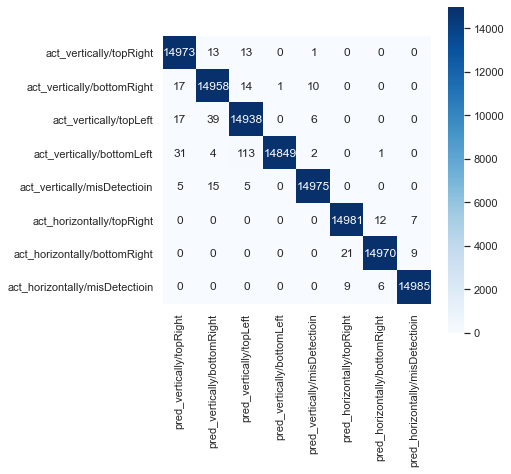

In [20]:
plt.figure(figsize = (6, 6))
sns.heatmap(cm, square=True, cbar=True, annot=True, fmt='d', cmap='Blues')

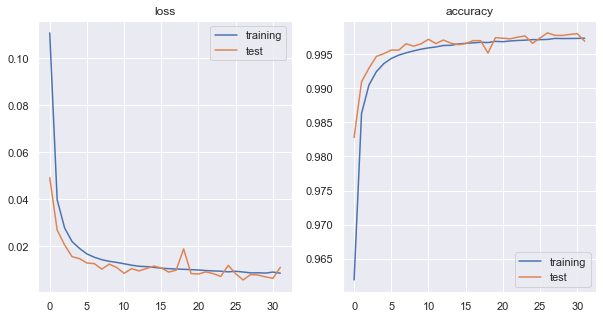

In [21]:
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
 
plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意
 
for i in range(len(metrics)):
 
    metric = metrics[i]
 
    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分け、i+1番目のスペースを使う
    plt.title(metric)  # グラフのタイトルを表示
    
    plt_train = history.history[metric]  # historyから訓練データの評価を取り出す
    plt_test = history.history['val_' + metric]  # historyからテストデータの評価を取り出す
    
    plt.plot(plt_train, label='training')  # 訓練データの評価をグラフにプロット
    plt.plot(plt_test, label='validation')  # テストデータの評価をグラフにプロット
    plt.legend()  # ラベルの表示
    
plt.show()  # グラフの表示

In [22]:
dt_now = datetime.datetime.now()
dt_now = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
my_model_path = 'tatakimodel' + dt_now + '.h5'
print(my_model_path)

model.save(my_model_path)

tatakimodel2023-01-23-07-59-50.h5


In [23]:
import tensorflowjs as tfjs

dt_now = datetime.datetime.now()
dt_now = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
tfjs_target_dir = './tfjs' + dt_now
print(tfjs_target_dir)

tfjs.converters.save_keras_model(model, tfjs_target_dir)

./tfjs2023-01-23-07-59-50


In [24]:
from sklearn.metrics import accuracy_score
a = accuracy_score(y_true, y_pred)

a

0.9969083333333333

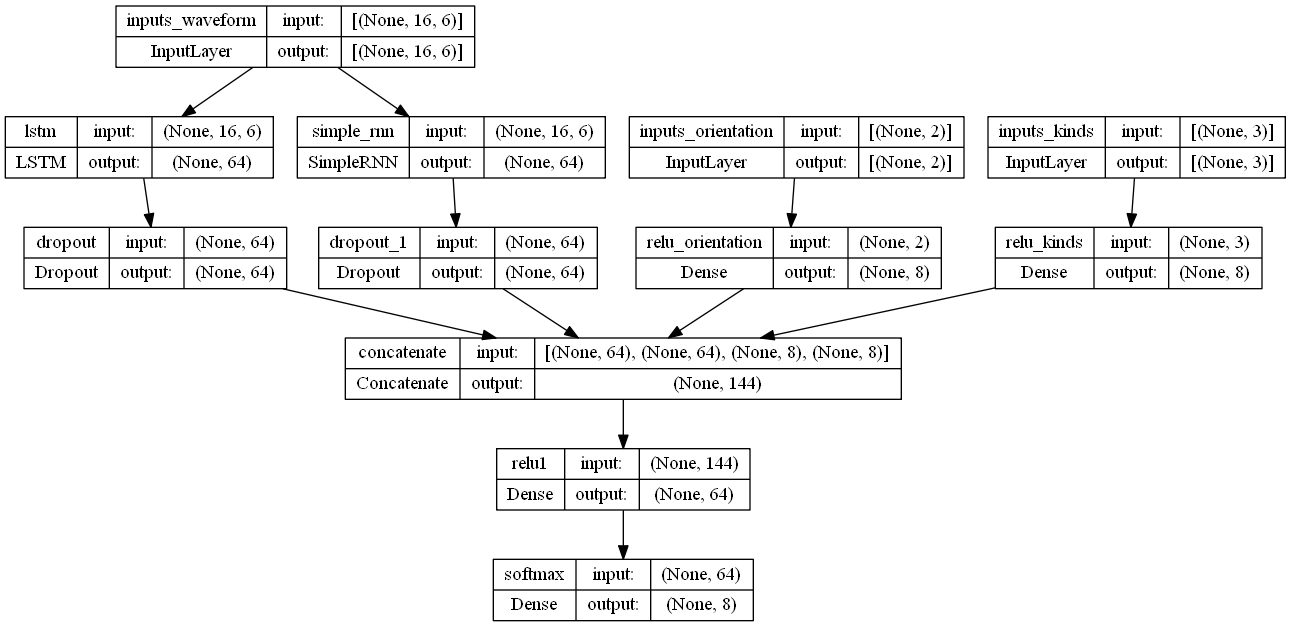

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)